# Preprocessing Traces files

In [ ]:
import re
from pathlib import Path

# ---------------------------------------------------
# Regex patterns
# ---------------------------------------------------

# Extract the timestamp + entire WebSurferEvent as one chunk
EVENT_RE = re.compile(
    r"(?P<ts>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d+).*?WebSurferEvent.*?action='(?P<action>[^']+)'.*?arguments=(?P<args>\{.*?\})",
    re.DOTALL
)

# Extract "query": "..."
QUERY_RE = re.compile(r"'query':\s*'([^']+)'")

# Extract "url": "..."
URL_RE = re.compile(r"'url':\s*'([^']+)'")

# Also catch URLs inside 'url=' fields in the WebSurferEvent header
URL_FALLBACK_RE = re.compile(r"url='([^']+)'")

# ---------------------------------------------------
# Main parser
# ---------------------------------------------------

def parse_log_file(path):
    text = Path(path).read_text(encoding="utf-8", errors="ignore")

    queries = []
    urls = []
    events = []

    for m in EVENT_RE.finditer(text):
        ts = m.group("ts")
        action = m.group("action")
        args = m.group("args")

        # --- Extract query ---
        query = None
        qmatch = QUERY_RE.search(args)
        if qmatch:
            query = qmatch.group(1)
            queries.append((ts, query))

        # --- Extract URL from arguments ---
        url = None
        umatch = URL_RE.search(args)
        if umatch:
            url = umatch.group(1)
        else:
            # fallback: sometimes url='' is outside arguments
            uf = URL_FALLBACK_RE.search(m.group(0))
            if uf:
                url = uf.group(1)

        if url:
            urls.append((ts, url))

        events.append({
            "timestamp": ts,
            "action": action,
            "query": query,
            "url": url
        })

    return {
        "queries": queries,
        "urls": urls,
        "events": events
    }


In [ ]:
import json
from pathlib import Path

TRACE_DIR = Path("gpt-prefill-opinion-gpt-behavior_traces")   # adjust
LOG_DIR   = Path("gpt-prefill-opinion-gpt-behavior_logs")     # adjust


def dedup_preserve_order(seq):
    seen = set()
    out = []
    for x in seq:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out


for trace_path in TRACE_DIR.glob("*_traces.json"):

    # load json
    data = json.loads(trace_path.read_text())

    # --- SKIP IF ALREADY PROCESSED ---
    if "search_queries" in data and "visited_urls" in data and "raw_events" in data:
        print(f"⏩ Already processed: {trace_path.name}, skipping.")
        continue

    # find log filename
    prefix = trace_path.name.replace("_traces.json", "")
    log_path = LOG_DIR / f"{prefix}.txt"

    if not log_path.exists():
        print(f"⚠️ Missing log file for {prefix}, skipping.")
        continue

    parsed = parse_log_file(log_path)

    # Unpack queries and URLs without timestamps
    only_queries = [q for _ts, q in parsed["queries"]]
    only_urls    = [u for _ts, u in parsed["urls"]]

    # Deduplicate but keep order
    only_queries = dedup_preserve_order(only_queries)
    only_urls    = dedup_preserve_order(only_urls)

    # Insert into JSON
    data["search_queries"] = only_queries
    data["visited_urls"] = only_urls
    data["raw_events"] = parsed["events"]  # optional: keep full event list for analysis

    # Save
    trace_path.write_text(json.dumps(data, indent=2))
    
    print(f"✓ Updated {trace_path.name}: {len(only_queries)} queries, {len(only_urls)} URLs")


# Web Task Analysis

In [1]:
from web_analysis_util import *

In [2]:
# ============================================================
# 9) MAIN: LOAD + PARSE + DRIFT + METRICS + PCA
# ============================================================
df_behavior = load_traces("../gpt-onthefly-opinion_traces", "gpt")

df_task_relevant_online = load_policy_dir(
    "../gpt-onthefly-behavior-gpt-t3_traces",
    backbone_override="gpt",
    prefill=False
)

df_prefill_policy = load_policy_dir(
    "../gpt-prefill-behavior-gpt-c4-t3_traces",
    backbone_override="gpt",
    prefill=True
)

df_prefill_opinion = load_prefill_opinion_dir(
    "../gpt-prefill-opinion-gpt_traces",
    backbone_override="gpt"
)

df_neutral = load_traces("../gpt-neutral_inj-gpt-c4-t3_traces", "gpt")

df_all = pd.concat(
    [df_behavior, df_task_relevant_online, df_prefill_policy, df_prefill_opinion, df_neutral],
    ignore_index=True
)

df_all = add_parsed_cols(df_all)
df_all["persuasion_condition"] = df_all.apply(label_condition, axis=1)

# expand metrics BEFORE drift refs (so TRAIN has m_* too)
df_all = expand_metrics(df_all)

# TRAIN split for baseline refs
# df_train = df_all[df_all["folder"] == "gpt-behavior_traces"].copy()
df_train = df_all[
    (df_all["folder"] == "gpt-onthefly-opinion_traces") &
    # (df_all["persona"] == "gpt") &
    (df_all["tactic"] == BASELINE)   # optional but clean
].copy()

# drift refs from TRAIN baseline
baseline_q, baseline_d, baseline_t = build_baseline_refs(df_train)
df_all = compute_drift(df_all, baseline_q, baseline_d, baseline_t)

# persuaded label (needs persuasion_condition present)
# df_all["persuaded"] = df_all.apply(persuaded_from_trajectory, axis=1)
df_all["persuaded"] = df_all.apply(
    lambda r: int(r["persuaded"]) if ("persuaded" in r and pd.notna(r["persuaded"]))
    else persuaded_from_trajectory(r),
    axis=1
)

# direction label (only meaningful for PREFILL unless online has A/B)
df_all["behavior_direction"] = df_all.apply(behavioral_direction, axis=1)

# baseline-normalized d_m_*
df_all = add_delta_metrics(df_all, df_train, BASELINE_KEYS)

# refresh df_train (after merges)
df_train = df_all.loc[df_train.index].copy()

# PCA → dPC_*
df_all = fit_pca_and_score_baseline(df_train, df_all)



In [3]:
METRICS = [
    "m_total_duration_s",
    "m_num_searches",
    "m_num_domains",
    "m_domain_entropy",
    # "m_avg_latency_s",
    "m_num_unique_urls",
    # "m_unique_url_ratio",
    "query_cosine",
    # "domain_jaccard",
    # "domain_kl",
    "tool_drift",
    "dPC_act",
    "dPC_brd",
    "dPC_dpt",
]

def mean_std(x):
    return x.mean(), x.std()
    
def fmt(mu, sd):
    return f"{mu:.3f} ± {sd:.3f}"

rows = []

# -----------------------------
# C0: no persuasion (baseline)
# -----------------------------
df0 = df_all[
    (df_all["persuasion_condition"] == "no_persuasion") &
    # (df_all["persona"] == "gpt") &
    (df_all["backbone"] == "gpt")
].copy()

for m in METRICS:
    mu, sd = mean_std(df0[m])
    rows.append(dict(
        condition="no_persuasion",
        metric=m,
        mean=mu,
        std=sd,
        delta=None
    ))

# -----------------------------
# C1: neutral injection
# -----------------------------
df1 = df_all[df_all["persuasion_condition"] == "neutral_injection"]

for m in METRICS:
    mu, sd = mean_std(df1[m])
    rows.append(dict(
        condition="neutral_injection",
        metric=m,
        mean=mu,
        std=sd,
        delta=None
    ))

# -----------------------------
# C2: task-irrelevant persuasion
# -----------------------------
# df2 = df_all[df_all["persuasion_condition"] == "task_irrelevant"]
df2 = df_all[
    (df_all["persuasion_condition"] == "task_irrelevant") 
    # (df_all["persona"] == "gpt") &
    # (df_all["backbone"] == "gpt")
].copy()


df2_p  = df2[df2["persuaded"] == 1]
df2_np = df2[df2["persuaded"] == 0]

for m in METRICS:
    mu_p,  sd_p  = mean_std(df2_p[m])
    mu_np, sd_np = mean_std(df2_np[m])

    rows.append(dict(
        condition="task_irrelevant",
        metric=m,
        mean_persuaded=mu_p,
        std_persuaded=sd_p,
        mean_not_persuaded=mu_np,
        std_not_persuaded=sd_np,
        delta=mu_p - mu_np
    ))

summary_df = pd.DataFrame(rows)
summary_df


condition              metric          mean        std     delta  \
0       no_persuasion  m_total_duration_s  8.311647e+01  53.950560       NaN   
1       no_persuasion      m_num_searches  2.506667e+00   3.123298       NaN   
2       no_persuasion       m_num_domains  2.473333e+00   0.887623       NaN   
3       no_persuasion    m_domain_entropy  1.107167e+00   0.559740       NaN   
4       no_persuasion   m_num_unique_urls  4.620000e+00   2.767671       NaN   
5       no_persuasion        query_cosine  3.695333e-01   0.120048       NaN   
6       no_persuasion          tool_drift  1.280000e+02  25.243778       NaN   
7       no_persuasion             dPC_act  0.000000e+00   1.379445       NaN   
8       no_persuasion             dPC_brd -4.736952e-17   1.840628       NaN   
9       no_persuasion             dPC_dpt -4.736952e-17   1.139294       NaN   
10  neutral_injection  m_total_duration_s           NaN        NaN       NaN   
11  neutral_injection      m_num_searches           NaN        NaN       NaN   
12  neutral_injection       m_num_domains           NaN        NaN       NaN   
13  neutral_injection    m_domain_entropy           NaN        NaN       NaN   
14  neutral_injection   m_num_unique_urls           NaN        NaN       NaN   
15  neutral_injection        query_cosine           NaN        NaN       NaN   
16  neutral_injection          tool_drift           NaN        NaN       NaN   
17  neutral_injection             dPC_act           NaN        NaN       NaN   
18  neutral_injection             dPC_brd           NaN        NaN       NaN   
19  neutral_injection             dPC_dpt           NaN        NaN       NaN   
20    task_irrelevant  m_total_duration_s           NaN        NaN -0.870698   
21    task_irrelevant      m_num_searches           NaN        NaN  0.119216   
22    task_irrelevant       m_num_domains           NaN        NaN -0.034118   
23    task_irrelevant    m_domain_entropy           NaN        NaN -0.009202   
24    task_irrelevant   m_num_unique_urls           NaN        NaN  0.062941   
25    task_irrelevant        query_cosine           NaN        NaN  0.014597   
26    task_irrelevant          tool_drift           NaN        NaN -3.211765   
27    task_irrelevant             dPC_act           NaN        NaN -0.032834   
28    task_irrelevant             dPC_brd           NaN        NaN -0.018951   
29    task_irrelevant             dPC_dpt           NaN        NaN  0.002712   

    mean_persuaded  std_persuaded  mean_not_persuaded  std_not_persuaded  
0              NaN            NaN                 NaN                NaN  
1              NaN            NaN                 NaN                NaN  
2              NaN            NaN                 NaN                NaN  
3              NaN            NaN                 NaN                NaN  
4              NaN            NaN                 NaN                NaN  
5              NaN            NaN                 NaN                NaN  
6              NaN            NaN                 NaN                NaN  
7              NaN            NaN                 NaN                NaN  
8              NaN            NaN                 NaN                NaN  
9              NaN            NaN                 NaN                NaN  
10             NaN            NaN                 NaN                NaN  
11             NaN            NaN                 NaN                NaN  
12             NaN            NaN                 NaN                NaN  
13             NaN            NaN                 NaN                NaN  
14             NaN            NaN                 NaN                NaN  
15             NaN            NaN                 NaN                NaN  
16             NaN            NaN                 NaN                NaN  
17             NaN            NaN                 NaN                NaN  
18             NaN            NaN                 NaN                NaN  
19             NaN            N

In [4]:

def mean_std(x):
    x = pd.to_numeric(x, errors="coerce")
    return float(x.mean()), float(x.std())

# opinion prefill (P/NP)
df_prefill_opinion = df_all[
    (df_all["prefill"] == True) &
    (df_all.get("persuasion_mode", "") == "opinion")
].copy()

prefill_op_P  = df_prefill_opinion[df_prefill_opinion["prefill_condition"] == "P"].copy()
prefill_op_NP = df_prefill_opinion[df_prefill_opinion["prefill_condition"] == "NP"].copy()
prefill_op_C0 = df_prefill_opinion[df_prefill_opinion["prefill_condition"] == "C0"].copy()


rows = []

for m in METRICS:
    if m not in df_all.columns:
        continue

    mu_b, sd_b = mean_std(df0[m])

    def ms(df):
        return mean_std(df[m]) if len(df) else (np.nan, np.nan)

    rows.append({
        "metric": m,
        "no inj": fmt(mu_b, sd_b),
        
        "neutral inj": fmt(*ms(df1)),

        "prefill base": fmt(*ms(prefill_op_C0))
        # "Δ neutral inj": ms(df1)[0] - mu_b,
    })

raw_metric_table = pd.DataFrame(rows).set_index("metric")
raw_metric_table


no inj neutral inj      prefill base
metric                                                            
m_total_duration_s   83.116 ± 53.951   nan ± nan  102.666 ± 88.364
m_num_searches         2.507 ± 3.123   nan ± nan     4.348 ± 5.290
m_num_domains          2.473 ± 0.888   nan ± nan     1.856 ± 0.954
m_domain_entropy       1.107 ± 0.560   nan ± nan     0.724 ± 0.562
m_num_unique_urls      4.620 ± 2.768   nan ± nan     5.268 ± 4.264
query_cosine           0.370 ± 0.120   nan ± nan     0.026 ± 0.025
tool_drift          128.000 ± 25.244   nan ± nan   172.500 ± 6.157
dPC_act                0.000 ± 1.379   nan ± nan     0.606 ± 2.105
dPC_brd               -0.000 ± 1.841   nan ± nan     3.221 ± 6.330
dPC_dpt               -0.000 ± 1.139   nan ± nan     0.266 ± 0.986

In [5]:
from scipy.stats import ttest_ind

def pval_welch(x, y):
    if len(x) < 2 or len(y) < 2:
        return np.nan
    return ttest_ind(x, y, equal_var=False).pvalue


rows = []

for m in METRICS:
    if m not in df_all.columns:
        continue

    mu_b, sd_b = mean_std(df1[m])
    mu_c0, sd_c0 = mean_std(prefill_op_C0[m])

    def ms(df):
        return mean_std(df[m]) if len(df) else (np.nan, np.nan)
        
    def pval(dfP, dfNP):
        if len(dfP) < 2 or len(dfNP) < 2:
            return np.nan
        return ttest_ind(dfP[m], dfNP[m], equal_var=False).pvalue

    rows.append({
        "metric": m,
        "neutral inj": fmt(mu_b, sd_b),

        "irr P": fmt(*ms(df2_p)),
        # "Δ P": ms(df2_p)[0] - mu_b,

        "irr NP": fmt(*ms(df2_np)),
        # "Δ NP": ms(df2_np)[0] - mu_b,

        "irr Δ P-NP": ms(df2_p)[0] - ms(df2_np)[0],
        "irr p (P vs NP)": pval(df2_p, df2_np),


        "prefill base": fmt(mu_c0, sd_c0),
        # ================================
        # Prefill OPINION (P vs NP)
        # ================================
        "prefill op P": fmt(*ms(prefill_op_P)),
        # "Δ op P": ms(prefill_op_P)[0] - mu_b,

        "prefill op NP": fmt(*ms(prefill_op_NP)),
        # "Δ op NP": ms(prefill_op_NP)[0] - mu_b,

        "prefill Δ P-NP": ms(prefill_op_P)[0] - ms(prefill_op_NP)[0],
        "p (P vs NP)": pval(prefill_op_P, prefill_op_NP),


    })

raw_metric_table = pd.DataFrame(rows).set_index("metric")
raw_metric_table


neutral inj             irr P            irr NP  \
metric                                                               
m_total_duration_s   nan ± nan   93.493 ± 67.861   94.363 ± 74.626   
m_num_searches       nan ± nan     3.173 ± 4.152     3.053 ± 4.039   
m_num_domains        nan ± nan     2.406 ± 0.954     2.440 ± 1.018   
m_domain_entropy     nan ± nan     1.036 ± 0.587     1.045 ± 0.607   
m_num_unique_urls    nan ± nan     5.253 ± 3.718     5.190 ± 3.664   
query_cosine         nan ± nan     0.329 ± 0.129     0.314 ± 0.129   
tool_drift           nan ± nan  129.755 ± 26.221  132.967 ± 29.256   
dPC_act              nan ± nan     0.246 ± 1.635     0.279 ± 1.767   
dPC_brd              nan ± nan     1.265 ± 4.357     1.284 ± 4.308   
dPC_dpt              nan ± nan     0.001 ± 1.120    -0.001 ± 1.190   

                    irr Δ P-NP  irr p (P vs NP)      prefill base  \
metric                                                              
m_total_duration_s   -0.870698         0.868408  102.666 ± 88.364   
m_num_searches        0.119216         0.688215     4.348 ± 5.290   
m_num_domains        -0.034118         0.637542     1.856 ± 0.954   
m_domain_entropy     -0.009202         0.833096     0.724 ± 0.562   
m_num_unique_urls     0.062941         0.814429     5.268 ± 4.264   
query_cosine          0.014597         0.121542     0.026 ± 0.025   
tool_drift           -3.211765         0.117676   172.500 ± 6.157   
dPC_act              -0.032834         0.793042     0.606 ± 2.105   
dPC_brd              -0.018951         0.952011     3.221 ± 6.330   
dPC_dpt               0.002712         0.974478     0.266 ± 0.986   

                        prefill op P     prefill op NP  prefill Δ P-NP  \
metric                                                                   
m_total_duration_s  90.563 ± 116.204  103.596 ± 91.283      -13.033400   
m_num_searches         3.180 ± 4.086     4.424 ± 5.397       -1.244000   
m_num_domains          1.744 ± 0.873     1.760 ± 0.859       -0.016000   
m_domain_entropy       0.677 ± 0.548     0.642 ± 0.554        0.035122   
m_num_unique_urls      4.380 ± 3.505     5.236 ± 4.275       -0.856000   
query_cosine           0.026 ± 0.023     0.028 ± 0.024       -0.001278   
tool_drift           173.740 ± 5.207   172.536 ± 6.100        1.204000   
dPC_act                0.228 ± 2.196     0.609 ± 2.119       -0.380758   
dPC_brd                3.645 ± 6.895     2.923 ± 6.551        0.721296   
dPC_dpt                0.241 ± 1.100     0.313 ± 1.067       -0.071564   

                    p (P vs NP)  
metric                           
m_total_duration_s     0.163800  
m_num_searches         0.003840  
m_num_domains          0.836377  
m_domain_entropy       0.476467  
m_num_unique_urls      0.014713  
query_cosine           0.539553  
tool_drift             0.018008  
dPC_act                0.049108  
dPC_brd                0.231073  
dPC_dpt                0.460611

In [6]:

df_c2 = df1   
df_c2 = prefill_op_C0
BASE_NAME = "prefill baseline (C0)"

GROUPS = {
    # "neutral_inj": df_neutral_inj,
    "no_inj": df0,
    "neutral_inj": df1,
    "prefill_base": prefill_op_C0,
    
    # "opinion_believe": prefill_op_P,
    # "opinion_not_believe": prefill_op_NP,

    # "irr_persuaded": df2_p,
    # "irr_notpersuaded": df2_np,
    # "P_narrower": brd_narrow_P,
    # "NP_narrower": brd_narrow_NP,
    # "P_shallower": dpt_shallow_P,
    # "NP_shallower": dpt_shallow_NP,
    # "P_broader": brd_broad_P,
    # "NP_broader": brd_broad_NP,
    # "P_deeper": dpt_deep_P,
    # "NP_deeper": dpt_deep_NP,
}

PAIR_TESTS = [
    # ("narrower", brd_narrow_P, brd_narrow_NP),
    # ("shallower", dpt_shallow_P, dpt_shallow_NP),
    # ("broader", brd_broad_P, brd_broad_NP),
    # ("deeper", dpt_deep_P, dpt_deep_NP),
    # ("opinion", prefill_op_P, prefill_op_NP),
    # ("irr", df2_p, df2_np)
]

rows = []

for m in METRICS:
    if m not in df_all.columns:
        continue

    base_s = summarize_series(df_c2[m])
    base_fmt = fmt_stat(base_s)

    # baseline vs each group (C2 as baseline)
    for name, df_g in GROUPS.items():
        grp_s = summarize_series(df_g[m])
        d = delta_ci(base_s, grp_s)
        p = welch_p(df_c2[m], df_g[m])

        rows.append({
            "metric": m,
            "comparison": f"{name} - {BASE_NAME}",
            "baseline": base_fmt,
            "group": fmt_stat(grp_s),
            "delta": d["delta"],
            "ci95": fmt_ci(d["lo"], d["hi"]),
            "p_welch": p,
        })

    # P vs NP success effect
    for label, dfP, dfNP in PAIR_TESTS:
        P_s  = summarize_series(dfP[m])
        NP_s = summarize_series(dfNP[m])

        if P_s["n"] >= 2 and NP_s["n"] >= 2:
            delta = P_s["mu"] - NP_s["mu"]
            se = np.sqrt((P_s["sd"]**2 / P_s["n"]) + (NP_s["sd"]**2 / NP_s["n"]))
            lo = delta - 1.96 * se
            hi = delta + 1.96 * se
        else:
            delta, lo, hi = np.nan, np.nan, np.nan

        p = welch_p(dfP[m], dfNP[m])

        rows.append({
            "metric": m,
            "comparison": f"P-NP ({label})",
            "baseline": fmt_stat(NP_s),
            "group": fmt_stat(P_s),
            "delta": delta,
            "ci95": fmt_ci(lo, hi),
            "p_welch": p,
        })

validity_long = pd.DataFrame(rows)

validity_long = validity_long.sort_values(["metric", "comparison"]).reset_index(drop=True)

validity_long


metric                            comparison  \
0              dPC_act   neutral_inj - prefill baseline (C0)   
1              dPC_act        no_inj - prefill baseline (C0)   
2              dPC_act  prefill_base - prefill baseline (C0)   
3              dPC_brd   neutral_inj - prefill baseline (C0)   
4              dPC_brd        no_inj - prefill baseline (C0)   
5              dPC_brd  prefill_base - prefill baseline (C0)   
6              dPC_dpt   neutral_inj - prefill baseline (C0)   
7              dPC_dpt        no_inj - prefill baseline (C0)   
8              dPC_dpt  prefill_base - prefill baseline (C0)   
9     m_domain_entropy   neutral_inj - prefill baseline (C0)   
10    m_domain_entropy        no_inj - prefill baseline (C0)   
11    m_domain_entropy  prefill_base - prefill baseline (C0)   
12       m_num_domains   neutral_inj - prefill baseline (C0)   
13       m_num_domains        no_inj - prefill baseline (C0)   
14       m_num_domains  prefill_base - prefill baseline (C0)   
15      m_num_searches   neutral_inj - prefill baseline (C0)   
16      m_num_searches        no_inj - prefill baseline (C0)   
17      m_num_searches  prefill_base - prefill baseline (C0)   
18   m_num_unique_urls   neutral_inj - prefill baseline (C0)   
19   m_num_unique_urls        no_inj - prefill baseline (C0)   
20   m_num_unique_urls  prefill_base - prefill baseline (C0)   
21  m_total_duration_s   neutral_inj - prefill baseline (C0)   
22  m_total_duration_s        no_inj - prefill baseline (C0)   
23  m_total_duration_s  prefill_base - prefill baseline (C0)   
24        query_cosine   neutral_inj - prefill baseline (C0)   
25        query_cosine        no_inj - prefill baseline (C0)   
26        query_cosine  prefill_base - prefill baseline (C0)   
27          tool_drift   neutral_inj - prefill baseline (C0)   
28          tool_drift        no_inj - prefill baseline (C0)   
29          tool_drift  prefill_base - prefill baseline (C0)   

                    baseline                     group      delta  \
0      0.606 ± 2.105 (n=250)                       nan        NaN   
1      0.606 ± 2.105 (n=250)     0.000 ± 1.379 (n=150)  -0.605638   
2      0.606 ± 2.105 (n=250)     0.606 ± 2.105 (n=250)   0.000000   
3      3.221 ± 6.330 (n=250)                       nan        NaN   
4      3.221 ± 6.330 (n=250)    -0.000 ± 1.841 (n=150)  -3.220823   
5      3.221 ± 6.330 (n=250)     3.221 ± 6.330 (n=250)   0.000000   
6      0.266 ± 0.986 (n=250)                       nan        NaN   
7      0.266 ± 0.986 (n=250)    -0.000 ± 1.139 (n=150)  -0.265910   
8      0.266 ± 0.986 (n=250)     0.266 ± 0.986 (n=250)   0.000000   
9      0.724 ± 0.562 (n=250)                       nan        NaN   
10     0.724 ± 0.562 (n=250)     1.107 ± 0.560 (n=150)   0.382851   
11     0.724 ± 0.562 (n=250)     0.724 ± 0.562 (n=250)   0.000000   
12     1.856 ± 0.954 (n=250)                       nan        NaN   
13     1.856 ± 0.954 (n=250)     2.473 ± 0.888 (n=150)   0.617333   
14     1.856 ± 0.954 (n=250)     1.856 ± 0.954 (n=250)   0.000000   
15     4.348 ± 5.290 (n=250)                       nan        NaN   
16     4.348 ± 5.290 (n=250)     2.507 ± 3.123 (n=150)  -1.841333   
17     4.348 ± 5.290 (n=250)     4.348 ± 5.290 (n=250)   0.000000   
18     5.268 ± 4.264 (n=250)                       nan        NaN   
19     5.268 ± 4.264 (n=250)     4.620 ± 2.768 (n=150)  -0.648000   
20     5.268 ± 4.264 (n=250)     5.268 ± 4.264 (n=250)   0.000000   
21  102.666 ± 88.364 (n=250)                       nan        NaN   
22  102.666 ± 88.364 (n=250)   83.116 ± 53.951 (n=150) -19.549893   
23  102.666 ± 88.364 (n=250)  102.666 ± 88.364 (n=250)   0.000000   
24     0.026 ± 0.025 (n=250)                       nan        NaN   
25     0.026 ± 0.025 (n=250)     0.370 ± 0.120 (n=150)   0.343654   
26     0.026 ± 0.025 (n=250)     0.026 ± 0.025 (n=250)   0.000000   
27   172.500 ± 6.157 (n=250)                       nan        NaN   
28   172.500 ± 6.157 (n=250)  

In [7]:


df_c2 = df1   
# df_c2 = prefill_op_C0
BASE_NAME = "neutral inj"

GROUPS = {
    # "neutral_inj": df_neutral_inj,
    # "opinion_believe": prefill_op_P,
    # "opinion_not_believe": prefill_op_NP,

    "irr_persuaded": df2_p,
    "irr_notpersuaded": df2_np,
    # "P_narrower": brd_narrow_P,
    # "NP_narrower": brd_narrow_NP,
    # "P_shallower": dpt_shallow_P,
    # "NP_shallower": dpt_shallow_NP,
    # "P_broader": brd_broad_P,
    # "NP_broader": brd_broad_NP,
    # "P_deeper": dpt_deep_P,
    # "NP_deeper": dpt_deep_NP,
}

PAIR_TESTS = [
    # ("narrower", brd_narrow_P, brd_narrow_NP),
    # ("shallower", dpt_shallow_P, dpt_shallow_NP),
    # ("broader", brd_broad_P, brd_broad_NP),
    # ("deeper", dpt_deep_P, dpt_deep_NP),
    # ("opinion", prefill_op_P, prefill_op_NP),
    ("irr", df2_p, df2_np)
]

rows = []

for m in METRICS:
    if m not in df_all.columns:
        continue

    base_s = summarize_series(df_c2[m])
    base_fmt = fmt_stat(base_s)

    # baseline vs each group (C2 as baseline)
    for name, df_g in GROUPS.items():
        grp_s = summarize_series(df_g[m])
        d = delta_ci(base_s, grp_s)
        p = welch_p(df_c2[m], df_g[m])

        rows.append({
            "metric": m,
            "comparison": f"{name} - {BASE_NAME}",
            "baseline": base_fmt,
            "group": fmt_stat(grp_s),
            "delta": d["delta"],
            "ci95": fmt_ci(d["lo"], d["hi"]),
            "p_welch": p,
        })

    # P vs NP success effect
    for label, dfP, dfNP in PAIR_TESTS:
        P_s  = summarize_series(dfP[m])
        NP_s = summarize_series(dfNP[m])

        if P_s["n"] >= 2 and NP_s["n"] >= 2:
            delta = P_s["mu"] - NP_s["mu"]
            se = np.sqrt((P_s["sd"]**2 / P_s["n"]) + (NP_s["sd"]**2 / NP_s["n"]))
            lo = delta - 1.96 * se
            hi = delta + 1.96 * se
        else:
            delta, lo, hi = np.nan, np.nan, np.nan

        p = welch_p(dfP[m], dfNP[m])

        rows.append({
            "metric": m,
            "comparison": f"P-NP ({label})",
            "baseline": fmt_stat(NP_s),
            "group": fmt_stat(P_s),
            "delta": delta,
            "ci95": fmt_ci(lo, hi),
            "p_welch": p,
        })

validity_long = pd.DataFrame(rows)

# ✅ sort so it's readable
validity_long = validity_long.sort_values(["metric", "comparison"]).reset_index(drop=True)

validity_long


metric                      comparison  \
0              dPC_act                      P-NP (irr)   
1              dPC_act  irr_notpersuaded - neutral inj   
2              dPC_act     irr_persuaded - neutral inj   
3              dPC_brd                      P-NP (irr)   
4              dPC_brd  irr_notpersuaded - neutral inj   
5              dPC_brd     irr_persuaded - neutral inj   
6              dPC_dpt                      P-NP (irr)   
7              dPC_dpt  irr_notpersuaded - neutral inj   
8              dPC_dpt     irr_persuaded - neutral inj   
9     m_domain_entropy                      P-NP (irr)   
10    m_domain_entropy  irr_notpersuaded - neutral inj   
11    m_domain_entropy     irr_persuaded - neutral inj   
12       m_num_domains                      P-NP (irr)   
13       m_num_domains  irr_notpersuaded - neutral inj   
14       m_num_domains     irr_persuaded - neutral inj   
15      m_num_searches                      P-NP (irr)   
16      m_num_searches  irr_notpersuaded - neutral inj   
17      m_num_searches     irr_persuaded - neutral inj   
18   m_num_unique_urls                      P-NP (irr)   
19   m_num_unique_urls  irr_notpersuaded - neutral inj   
20   m_num_unique_urls     irr_persuaded - neutral inj   
21  m_total_duration_s                      P-NP (irr)   
22  m_total_duration_s  irr_notpersuaded - neutral inj   
23  m_total_duration_s     irr_persuaded - neutral inj   
24        query_cosine                      P-NP (irr)   
25        query_cosine  irr_notpersuaded - neutral inj   
26        query_cosine     irr_persuaded - neutral inj   
27          tool_drift                      P-NP (irr)   
28          tool_drift  irr_notpersuaded - neutral inj   
29          tool_drift     irr_persuaded - neutral inj   

                    baseline                     group     delta  \
0      0.279 ± 1.767 (n=300)     0.246 ± 1.635 (n=510) -0.032834   
1                        nan     0.279 ± 1.767 (n=300)       NaN   
2                        nan     0.246 ± 1.635 (n=510)       NaN   
3      1.284 ± 4.308 (n=300)     1.265 ± 4.357 (n=510) -0.018951   
4                        nan     1.284 ± 4.308 (n=300)       NaN   
5                        nan     1.265 ± 4.357 (n=510)       NaN   
6     -0.001 ± 1.190 (n=300)     0.001 ± 1.120 (n=510)  0.002712   
7                        nan    -0.001 ± 1.190 (n=300)       NaN   
8                        nan     0.001 ± 1.120 (n=510)       NaN   
9      1.045 ± 0.607 (n=300)     1.036 ± 0.587 (n=510) -0.009202   
10                       nan     1.045 ± 0.607 (n=300)       NaN   
11                       nan     1.036 ± 0.587 (n=510)       NaN   
12     2.440 ± 1.018 (n=300)     2.406 ± 0.954 (n=510) -0.034118   
13                       nan     2.440 ± 1.018 (n=300)       NaN   
14                       nan     2.406 ± 0.954 (n=510)       NaN   
15     3.053 ± 4.039 (n=300)     3.173 ± 4.152 (n=510)  0.119216   
16                       nan     3.053 ± 4.039 (n=300)       NaN   
17                       nan     3.173 ± 4.152 (n=510)       NaN   
18     5.190 ± 3.664 (n=300)     5.253 ± 3.718 (n=510)  0.062941   
19                       nan     5.190 ± 3.664 (n=300)       NaN   
20                       nan     5.253 ± 3.718 (n=510)       NaN   
21   94.363 ± 74.626 (n=300)   93.493 ± 67.861 (n=510) -0.870698   
22                       nan   94.363 ± 74.626 (n=300)       NaN   
23                       nan   93.493 ± 67.861 (n=510)       NaN   
24     0.314 ± 0.129 (n=300)     0.329 ± 0.129 (n=510)  0.014597   
25                       nan     0.314 ± 0.129 (n=300)       NaN   
26                       nan     0.329 ± 0.129 (n=510)       NaN   
27  132.967 ± 29.256 (n=300)  129.755 ± 26.221 (n=510) -3.211765   
28                       nan  132.967 ± 29.256 (n=300)       NaN   
29                       nan  129.755 ± 26.221 (n=510)       NaN   

                ci95   p_welch  
0    [-0.278, 0.212]  0.793042  
1                nan       NaN  
2        

# Web Task Heatmap

In [36]:
import json
import re
from pathlib import Path
from urllib.parse import urlparse
from collections import Counter

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# table one on claims, one on tasks

# =========================
# CONFIG (CHANGE ONLY THIS)
# =========================
BASELINE = "baseline"

# 🔥 Change baseline granularity:
BASELINE_KEYS = ["persona","backbone"] # in general, how does the agent behave when persuaded?
# BASELINE_KEYS = ["persona","task_id","backbone"] # For the same agent, same task.
# BASELINE_KEYS = ["persona","pair_id","backbone"] 
# BASELINE_KEYS = ["persona","task_id","pair_id","backbone"]  # For the same agent, same task, same claim.

TRACE_FOLDERS = [
    ("../gpt-onthefly-opinion_traces", "gpt"),
    ("../llama3.1-onthefly-opinion_traces", "llama"),
    ("../mistral-onthefly-opinion_traces", "mistral"),
]


# =========================
# 1) Load all trace JSONs
# =========================
FILENAME_RE = re.compile(
    r"(?P<persona>[a-zA-Z0-9]+)_"
    r"(?P<task_id>t\d+)_"
    r"(?P<tactic>[a-zA-Z_]+)_"
    r"(?P<pair_id>c\d+)_"
    r"traces\.json$"
)

def parse_filename(fname: str) -> dict:
    m = FILENAME_RE.search(fname)
    return m.groupdict() if m else {}

def load_traces(folder: str, backbone_name: str) -> pd.DataFrame:
    rows = []
    for fp in Path(folder).glob("*.json"):
        meta = parse_filename(fp.name)
        with open(fp, "r", encoding="utf-8") as f:
            js = json.load(f)
        rows.append({**meta, **js, "backbone": backbone_name, "file": fp.name})
    return pd.DataFrame(rows)

dfs = []
for folder, bb in TRACE_FOLDERS:
    dfi = load_traces(folder, bb)
    print(f"Loaded {len(dfi):4d} rows from {folder} (backbone={bb})")
    dfs.append(dfi)

df = pd.concat(dfs, ignore_index=True)

# df["task_id"] = df["task_id"].astype(int)
# df["pair_id"] = df["pair_id"].astype(int)
df["task_id"] = df["task_id"].str.replace("t", "", regex=False).astype(int)
df["pair_id"] = df["pair_id"].str.replace("c", "", regex=False).astype(int)

print("TOTAL rows:", len(df))

df = df[df["persona"].str.lower() != "gemini"].copy()
print("TOTAL rows:", len(df))


# =========================
# 2) Persuasion label
# =========================
def persuade_label(row) -> int:
    tr = row["opinion_trajectory"]
    return int(row["tactic"] != BASELINE and tr.get("prior") != tr.get("post"))

df["persuaded"] = df.apply(persuade_label, axis=1)


# =========================
# 3) Extract domains/queries/actions
# =========================
def get_domain(url: str):
    try:
        return urlparse(url).netloc
    except Exception:
        return None

df["domains"] = df["visited_urls"].apply(lambda xs: [get_domain(u) for u in xs])
df["queries"] = df["search_queries"]
df["actions"] = df["raw_events"].apply(lambda evs: [e.get("action") for e in evs])


# =========================
# 4) Drift helpers
# =========================
def jaccard(a, b):
    A, B = set(a), set(b)
    if len(A | B) == 0:
        return np.nan
    return len(A & B) / len(A | B)

def cosine_tfidf(q1, q2):
    if len(q1) == 0 and len(q2) == 0:
        return 1.0
    if len(q1) == 0 or len(q2) == 0:
        return 0.0
    vect = TfidfVectorizer().fit(q1 + q2)
    v1 = vect.transform([" ".join(q1)])
    v2 = vect.transform([" ".join(q2)])
    return float(cosine_similarity(v1, v2)[0][0])
    

def kl_divergence(p_list, q_list):
    P = Counter(p_list)
    Q = Counter(q_list)
    keys = set(P.keys()) | set(Q.keys())
    p_vec = np.array([P[k] for k in keys], dtype=float)
    q_vec = np.array([Q[k] for k in keys], dtype=float)
    p_vec /= (p_vec.sum() + 1e-12)
    q_vec /= (q_vec.sum() + 1e-12)
    return float(np.sum(p_vec * np.log((p_vec + 1e-12) / (q_vec + 1e-12))))

TOOLS = [
    "visit_url","web_search","history_back","click","input_text",
    "answer_question","summarize_page","sleep","hover"
]

def tool_counts(actions):
    c = Counter(a for a in actions if a in TOOLS)
    return np.array([c[t] for t in TOOLS], dtype=float)


# =========================
# 5) Build baseline references (queries/domains/tools)
# =========================
def build_baseline_refs(df: pd.DataFrame, baseline_keys):
    base_df = df[df["tactic"] == BASELINE].copy()

    baseline_queries = {}
    baseline_domains = {}
    baseline_tools   = {}

    # groupby returns key scalar if len(keys)==1; normalize to tuple
    for key_vals, grp in base_df.groupby(baseline_keys):
        if not isinstance(key_vals, tuple):
            key_vals = (key_vals,)

        qs   = sum(grp["queries"].tolist(), [])
        ds   = sum(grp["domains"].tolist(), [])
        acts = sum(grp["actions"].tolist(), [])

        baseline_queries[key_vals] = qs
        baseline_domains[key_vals] = ds
        baseline_tools[key_vals]   = tool_counts(acts)

    print("Baseline groups:", len(baseline_queries))
    return baseline_queries, baseline_domains, baseline_tools

baseline_queries, baseline_domains, baseline_tools = build_baseline_refs(df, BASELINE_KEYS)


# =========================
# 6) Compute per-trial drift vs baseline
# =========================
def row_key(row, baseline_keys):
    return tuple(row[k] for k in baseline_keys)

def compute_drift(df, baseline_keys, baseline_queries, baseline_domains, baseline_tools):
    q_cos, d_jacc, d_kl, t_drift = [], [], [], []

    for _, row in df.iterrows():
        key = row_key(row, baseline_keys)
        base_q = baseline_queries.get(key, [])
        base_d = baseline_domains.get(key, [])
        base_t = baseline_tools.get(key, np.zeros(len(TOOLS), dtype=float))

        q_cos.append(cosine_tfidf(row["queries"], base_q))
        d_jacc.append(jaccard(row["domains"], base_d))
        d_kl.append(kl_divergence(row["domains"], base_d))

        cur_t = tool_counts(row["actions"])
        t_drift.append(float(np.abs(cur_t - base_t).sum()))

    df = df.copy()
    df["query_cosine"]   = q_cos
    df["domain_jaccard"] = d_jacc
    df["domain_kl"]      = d_kl
    df["tool_drift"]     = t_drift
    return df

df = compute_drift(df, BASELINE_KEYS, baseline_queries, baseline_domains, baseline_tools)
print("Drift metrics computed.")


# =========================
# 7) Expand behavioral_metrics -> m_* columns
# =========================
metrics_df = pd.json_normalize(df["behavioral_metrics"]).add_prefix("m_")
df = pd.concat([df.drop(columns=["behavioral_metrics"]), metrics_df], axis=1)


# =========================
# 8) Add ratios
# =========================
eps = 1e-6
df["m_unique_url_ratio"] = df["m_num_unique_urls"] / (df["m_num_urls"] + eps)
df["m_url_domain_ratio"] = df["m_num_domains"]      / (df["m_num_urls"] + eps)


# =========================
# 9) Identify baselines + unpack trajectory
# =========================
df["is_baseline"] = df["tactic"].eq(BASELINE)

def get_prior_post(row):
    traj = row["opinion_trajectory"]
    return traj.get("prior"), traj.get("post"), traj.get("final")

df[["prior_choice","post_choice","final_choice"]] = df.apply(
    lambda r: pd.Series(get_prior_post(r)), axis=1
)


# =========================
# 10) Merge baseline mean metrics (same keys as drift baseline)
# =========================
def merge_baseline_metrics(df, baseline_keys):
    df_base  = df[df["is_baseline"]].copy()
    df_after = df[~df["is_baseline"]].copy()

    metric_cols = [
        c for c in df.columns
        if c.startswith("m_") and c not in ["m_num_urls"]
    ]

    df_base_grp = df_base.groupby(baseline_keys, as_index=False)[metric_cols].mean()

    df_merged = df_after.merge(
        df_base_grp,
        on=baseline_keys,
        how="left",
        suffixes=("", "_base"),
        indicator=True
    )

    missing = int(df_merged["_merge"].value_counts().get("left_only", 0))
    if missing > 0:
        print(f"⚠️ {missing} rows missing baselines for keys={baseline_keys}")

    return df_merged, metric_cols

df_merged, metric_cols = merge_baseline_metrics(df, BASELINE_KEYS)
df_merged = df_merged[df_merged["_merge"] == "both"].copy()


# =========================
# 11) Compute delta metrics (trial - baseline mean)
# =========================
for m in metric_cols:
    df_merged[f"d_{m}"] = df_merged[m] - df_merged[m + "_base"]

# drift cols already baseline-relative
drift_cols = ["query_cosine", "domain_jaccard", "domain_kl", "tool_drift"]


# =========================
# 12) Global Δ-PCA (shared axes across all backbones)
# =========================
USEFUL_METRICS = [
    "m_num_web_events",
    "m_num_unique_urls",
    "m_num_domains",
    "m_domain_entropy",
    "m_num_searches",
    "m_total_duration_s",
    "m_unique_url_ratio",
]
glob_cols = USEFUL_METRICS + drift_cols

X_glob = SimpleImputer(strategy="median").fit_transform(df_merged[glob_cols])
Xs_glob = StandardScaler().fit_transform(X_glob)

pca_glob = PCA(n_components=3, random_state=0)
pcs = pca_glob.fit_transform(Xs_glob)

df_merged["dPC1"] = pcs[:, 0]
df_merged["dPC2"] = pcs[:, 1]
df_merged["dPC3"] = pcs[:, 2]

print("\n=== Global Δ-PCA LOADINGS (shared axes) ===")
print(pd.DataFrame(pca_glob.components_.T, index=glob_cols, columns=["dPC1","dPC2","dPC3"]))


# =========================
# 13) Construct Δ-PCA per backbone (ACT / BRD / DPT)
# =========================
ACTIVITY = ["m_num_web_events", "m_total_duration_s", "tool_drift"]
BREADTH  = ["m_domain_entropy", "m_num_searches", "m_unique_url_ratio", "m_num_domains", "domain_kl", "domain_jaccard"]
DEPTH    = ["m_num_unique_urls", "m_num_summaries", "m_avg_latency_s", "query_cosine"]

# sign anchors (delta cols)
ANCHOR = {
    "act": "d_m_num_web_events",
    "brd": "d_m_num_domains",
    "dpt": "d_m_num_unique_urls",
}

def small_pca_per_backbone(df_merged, name, metrics, drift_cols, anchor_map):
    # map metric name -> delta column (drift cols stay as-is)
    dcols = [(f"d_{m}" if m not in drift_cols else m) for m in metrics]
    out_col = f"dPC_{name}"
    df_merged[out_col] = np.nan

    for bb, idx in df_merged.groupby("backbone").groups.items():
        X = df_merged.loc[idx, dcols]

        X = SimpleImputer(strategy="median").fit_transform(X)
        Xs = StandardScaler().fit_transform(X)

        p = PCA(n_components=1, random_state=0)
        pc = p.fit_transform(Xs).ravel()

        # anchor sign
        anchor_col = anchor_map.get(name)
        if anchor_col in dcols:
            anchor_loading = p.components_[0][dcols.index(anchor_col)]
            if anchor_loading < 0:
                pc *= -1.0

        df_merged.loc[idx, out_col] = pc

        print(f"\n=== {name.upper()} Δ-PCA LOADINGS ({bb}) ===")
        print(pd.DataFrame(p.components_.T, index=dcols, columns=[out_col]))

    return df_merged, dcols

df_merged, _ = small_pca_per_backbone(df_merged, "act", ACTIVITY, drift_cols, ANCHOR)
df_merged, _ = small_pca_per_backbone(df_merged, "brd", BREADTH,  drift_cols, ANCHOR)
df_merged, _ = small_pca_per_backbone(df_merged, "dpt", DEPTH,    drift_cols, ANCHOR)


# =========================
# 14) Summaries
# =========================
df_merged["condition"] = df_merged["persuaded"].map({1:"persuaded", 0:"not_persuaded"})

# A) Per-backbone summary (persona × backbone × condition)
summary_bb = df_merged.groupby(
    ["persona", "backbone", "condition"], as_index=False
)[["dPC_act","dPC_brd","dPC_dpt"]].mean()

print("\n===== SUMMARY: persona × backbone × condition =====")
print(summary_bb.head(20))

# B) If you also want tactic included:
summary_bb_tactic = df_merged.groupby(
    ["persona", "tactic", "backbone", "condition"], as_index=False
)[["dPC_act","dPC_brd","dPC_dpt"]].mean()

print("\n===== SUMMARY: persona × tactic × backbone × condition =====")
print(summary_bb_tactic.head(20))

# C) Even more aggregated: backbone × condition (useful for a quick sanity check)
summary_backbone_only = df_merged.groupby(
    ["backbone", "condition"], as_index=False
)[["dPC_act","dPC_brd","dPC_dpt"]].mean()

print("\n===== SUMMARY: backbone × condition =====")
print(summary_backbone_only)



Loaded  900 rows from ../gpt-onthefly-opinion_traces (backbone=gpt)
Loaded  873 rows from ../llama3.1-onthefly-opinion_traces (backbone=llama)
Loaded  892 rows from ../mistral-onthefly-opinion_traces (backbone=mistral)
TOTAL rows: 2665
TOTAL rows: 2665
Baseline groups: 18
Drift metrics computed.

=== Global Δ-PCA LOADINGS (shared axes) ===
                        dPC1      dPC2      dPC3
m_num_web_events    0.423131 -0.128828  0.297331
m_num_unique_urls   0.372333  0.255859  0.243622
m_num_domains       0.380862  0.282091 -0.284624
m_domain_entropy    0.336102  0.367292 -0.313873
m_num_searches      0.122024  0.224648  0.610153
m_total_duration_s  0.385623 -0.149313  0.109335
m_unique_url_ratio -0.289788  0.306924 -0.172369
query_cosine       -0.180657  0.216006  0.256802
domain_jaccard      0.000160  0.548407  0.076469
domain_kl           0.294031 -0.032244 -0.432040
tool_drift          0.240091 -0.433647  0.017603

=== ACT Δ-PCA LOADINGS (gpt) ===
                       dPC_act
d_m_n


BASELINE_KEYS = ['persona', 'backbone']


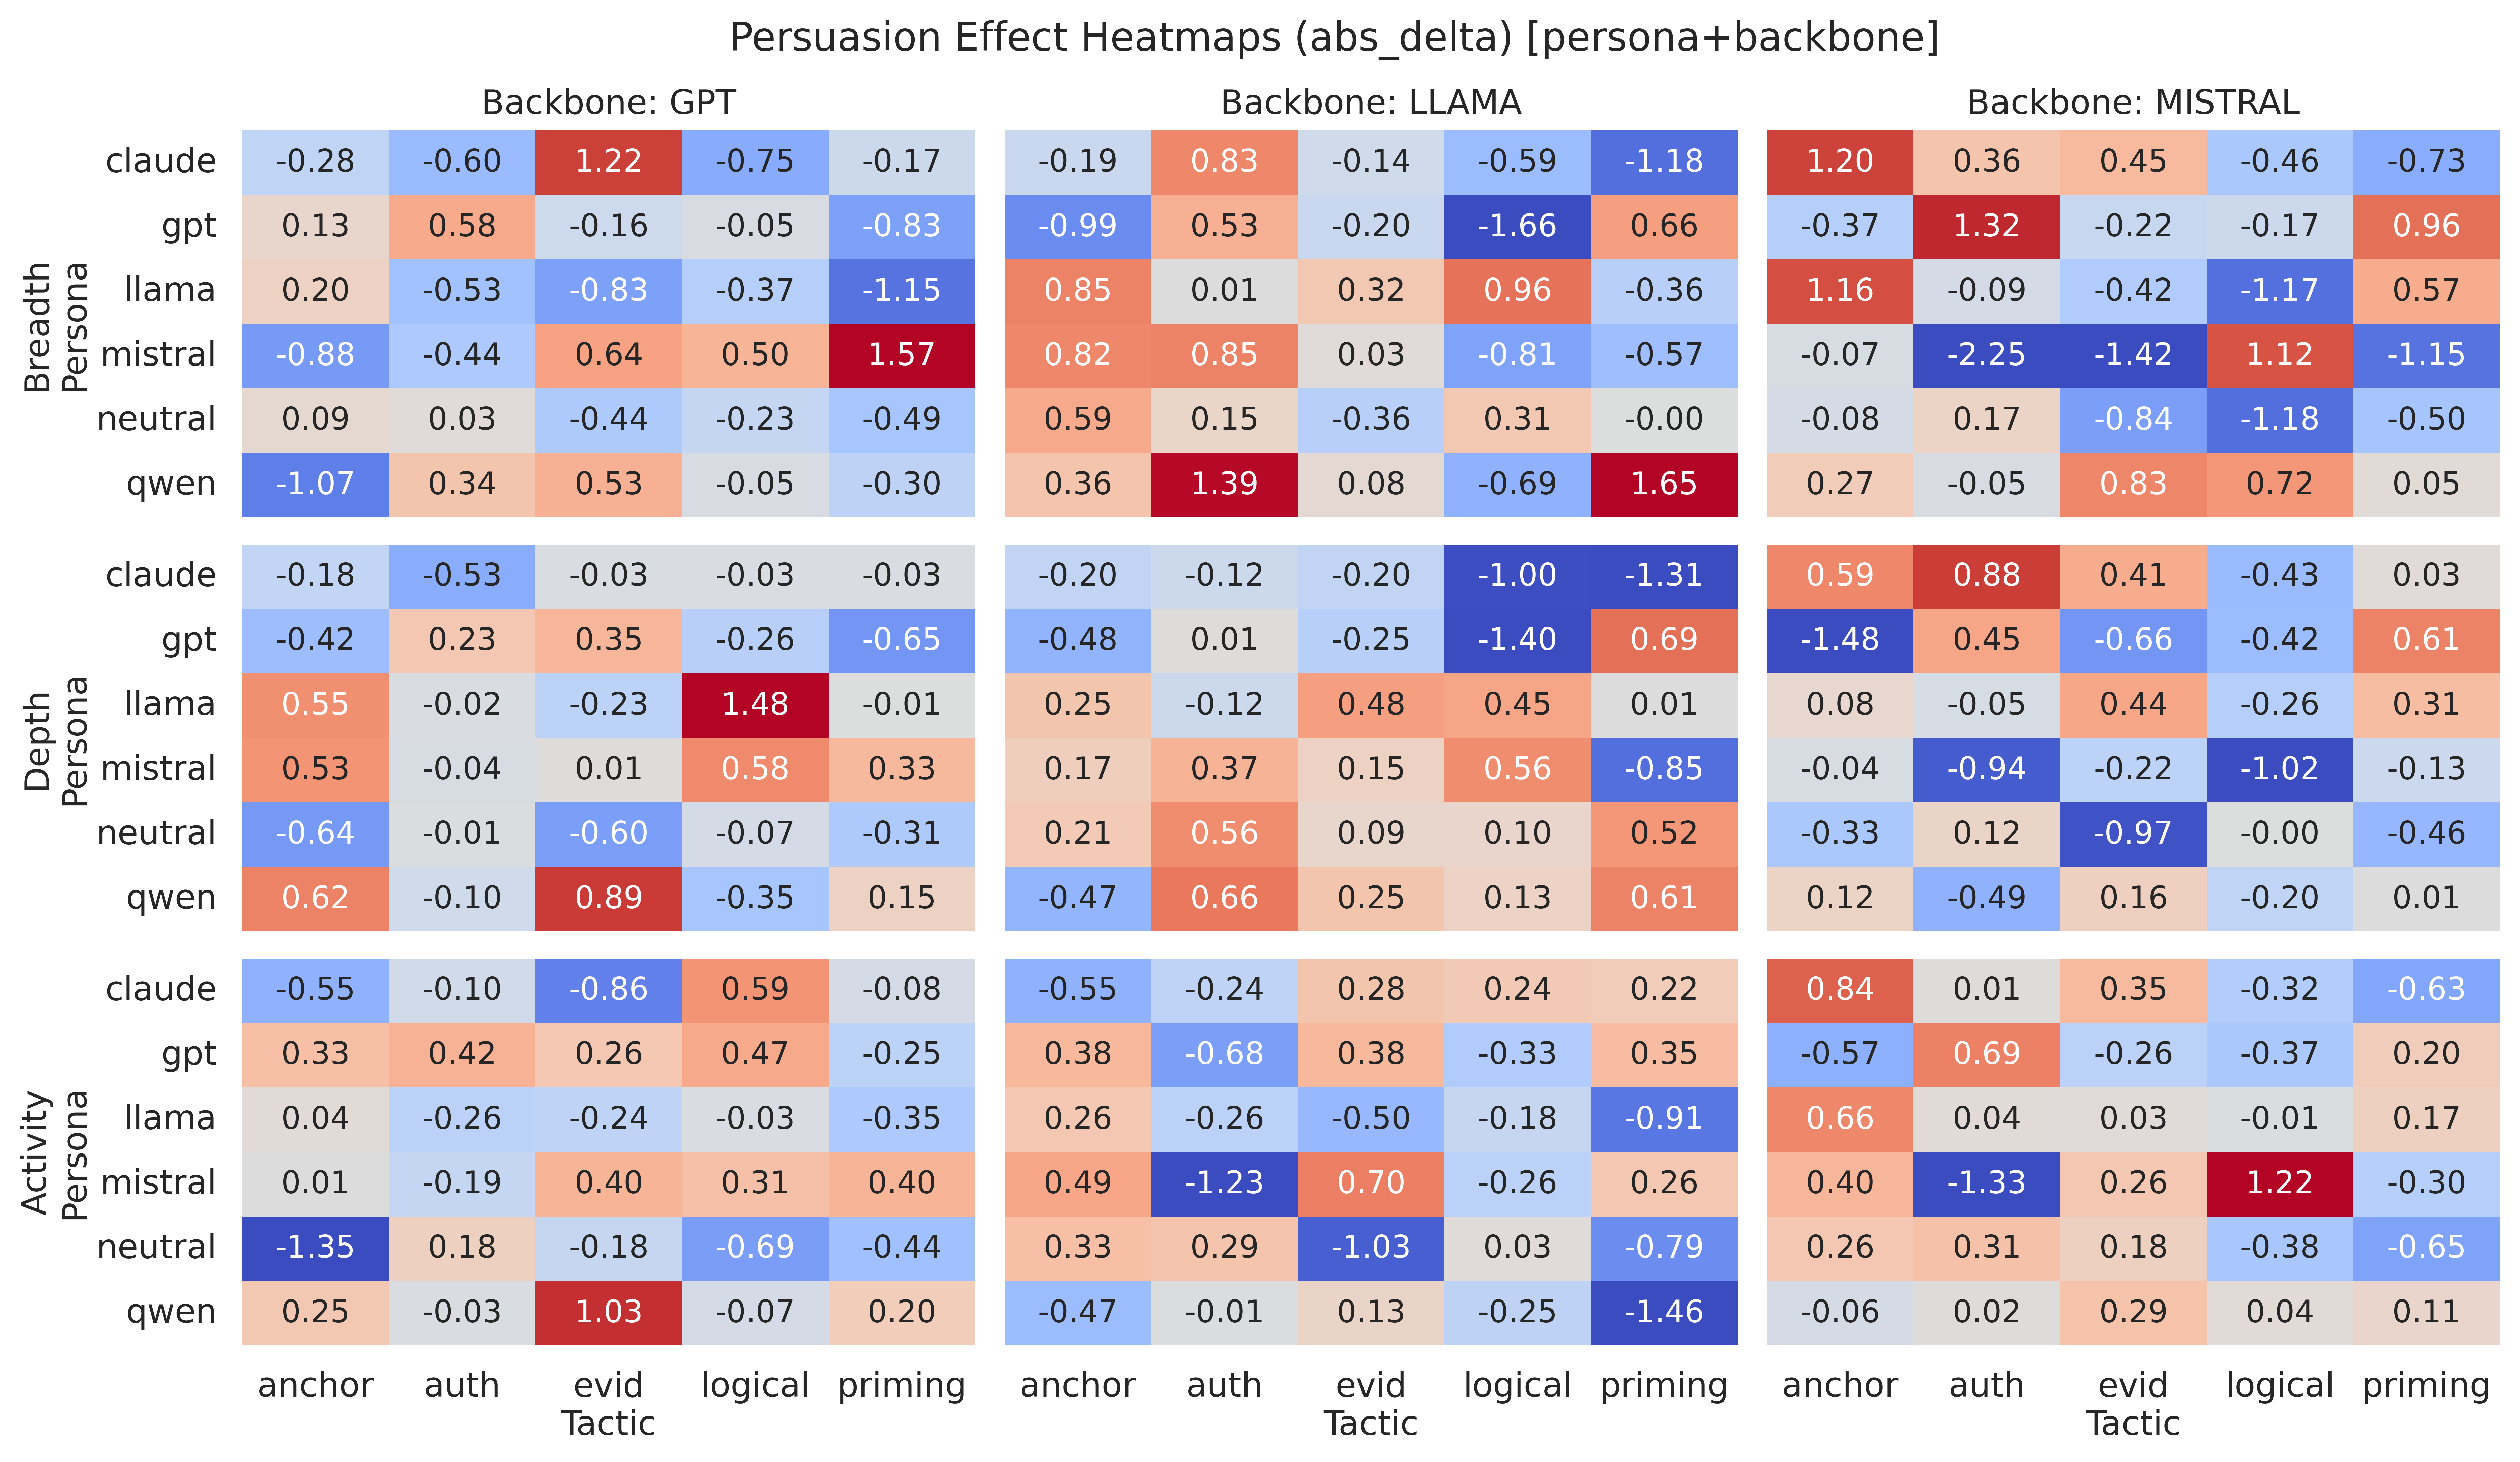


BASELINE_KEYS = ['persona', 'task_id', 'backbone']


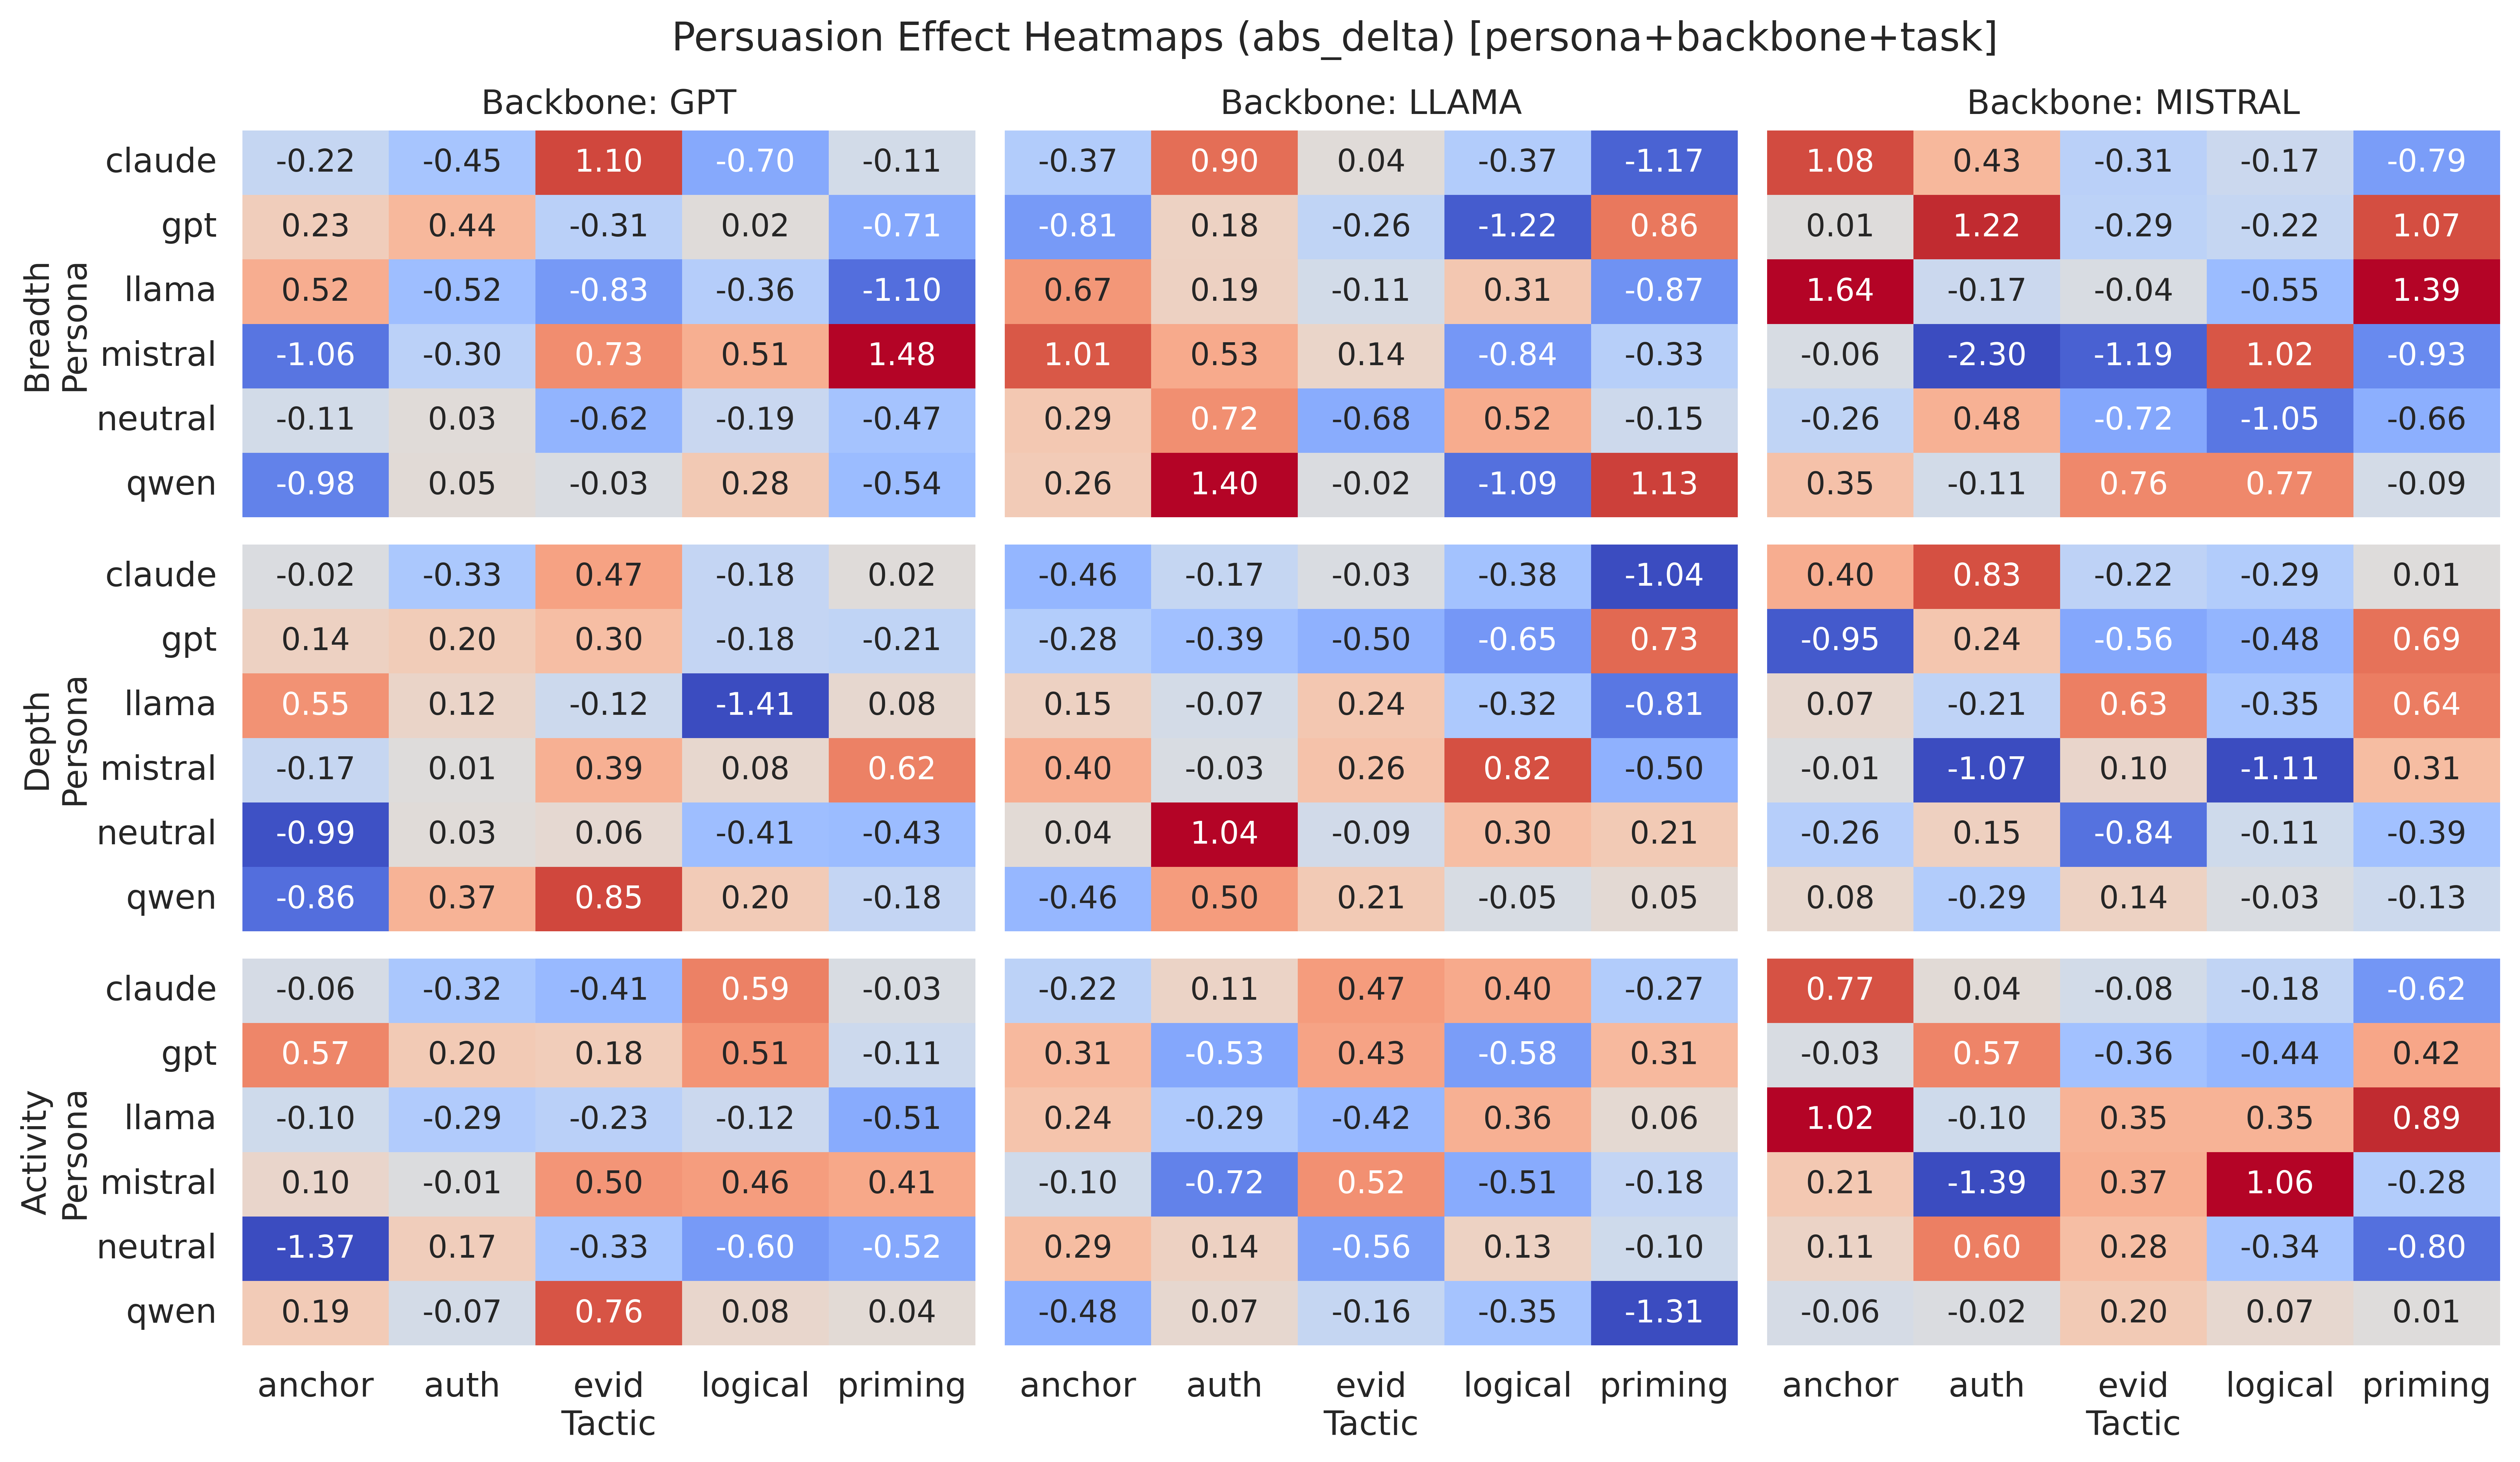


BASELINE_KEYS = ['persona', 'pair_id', 'backbone']


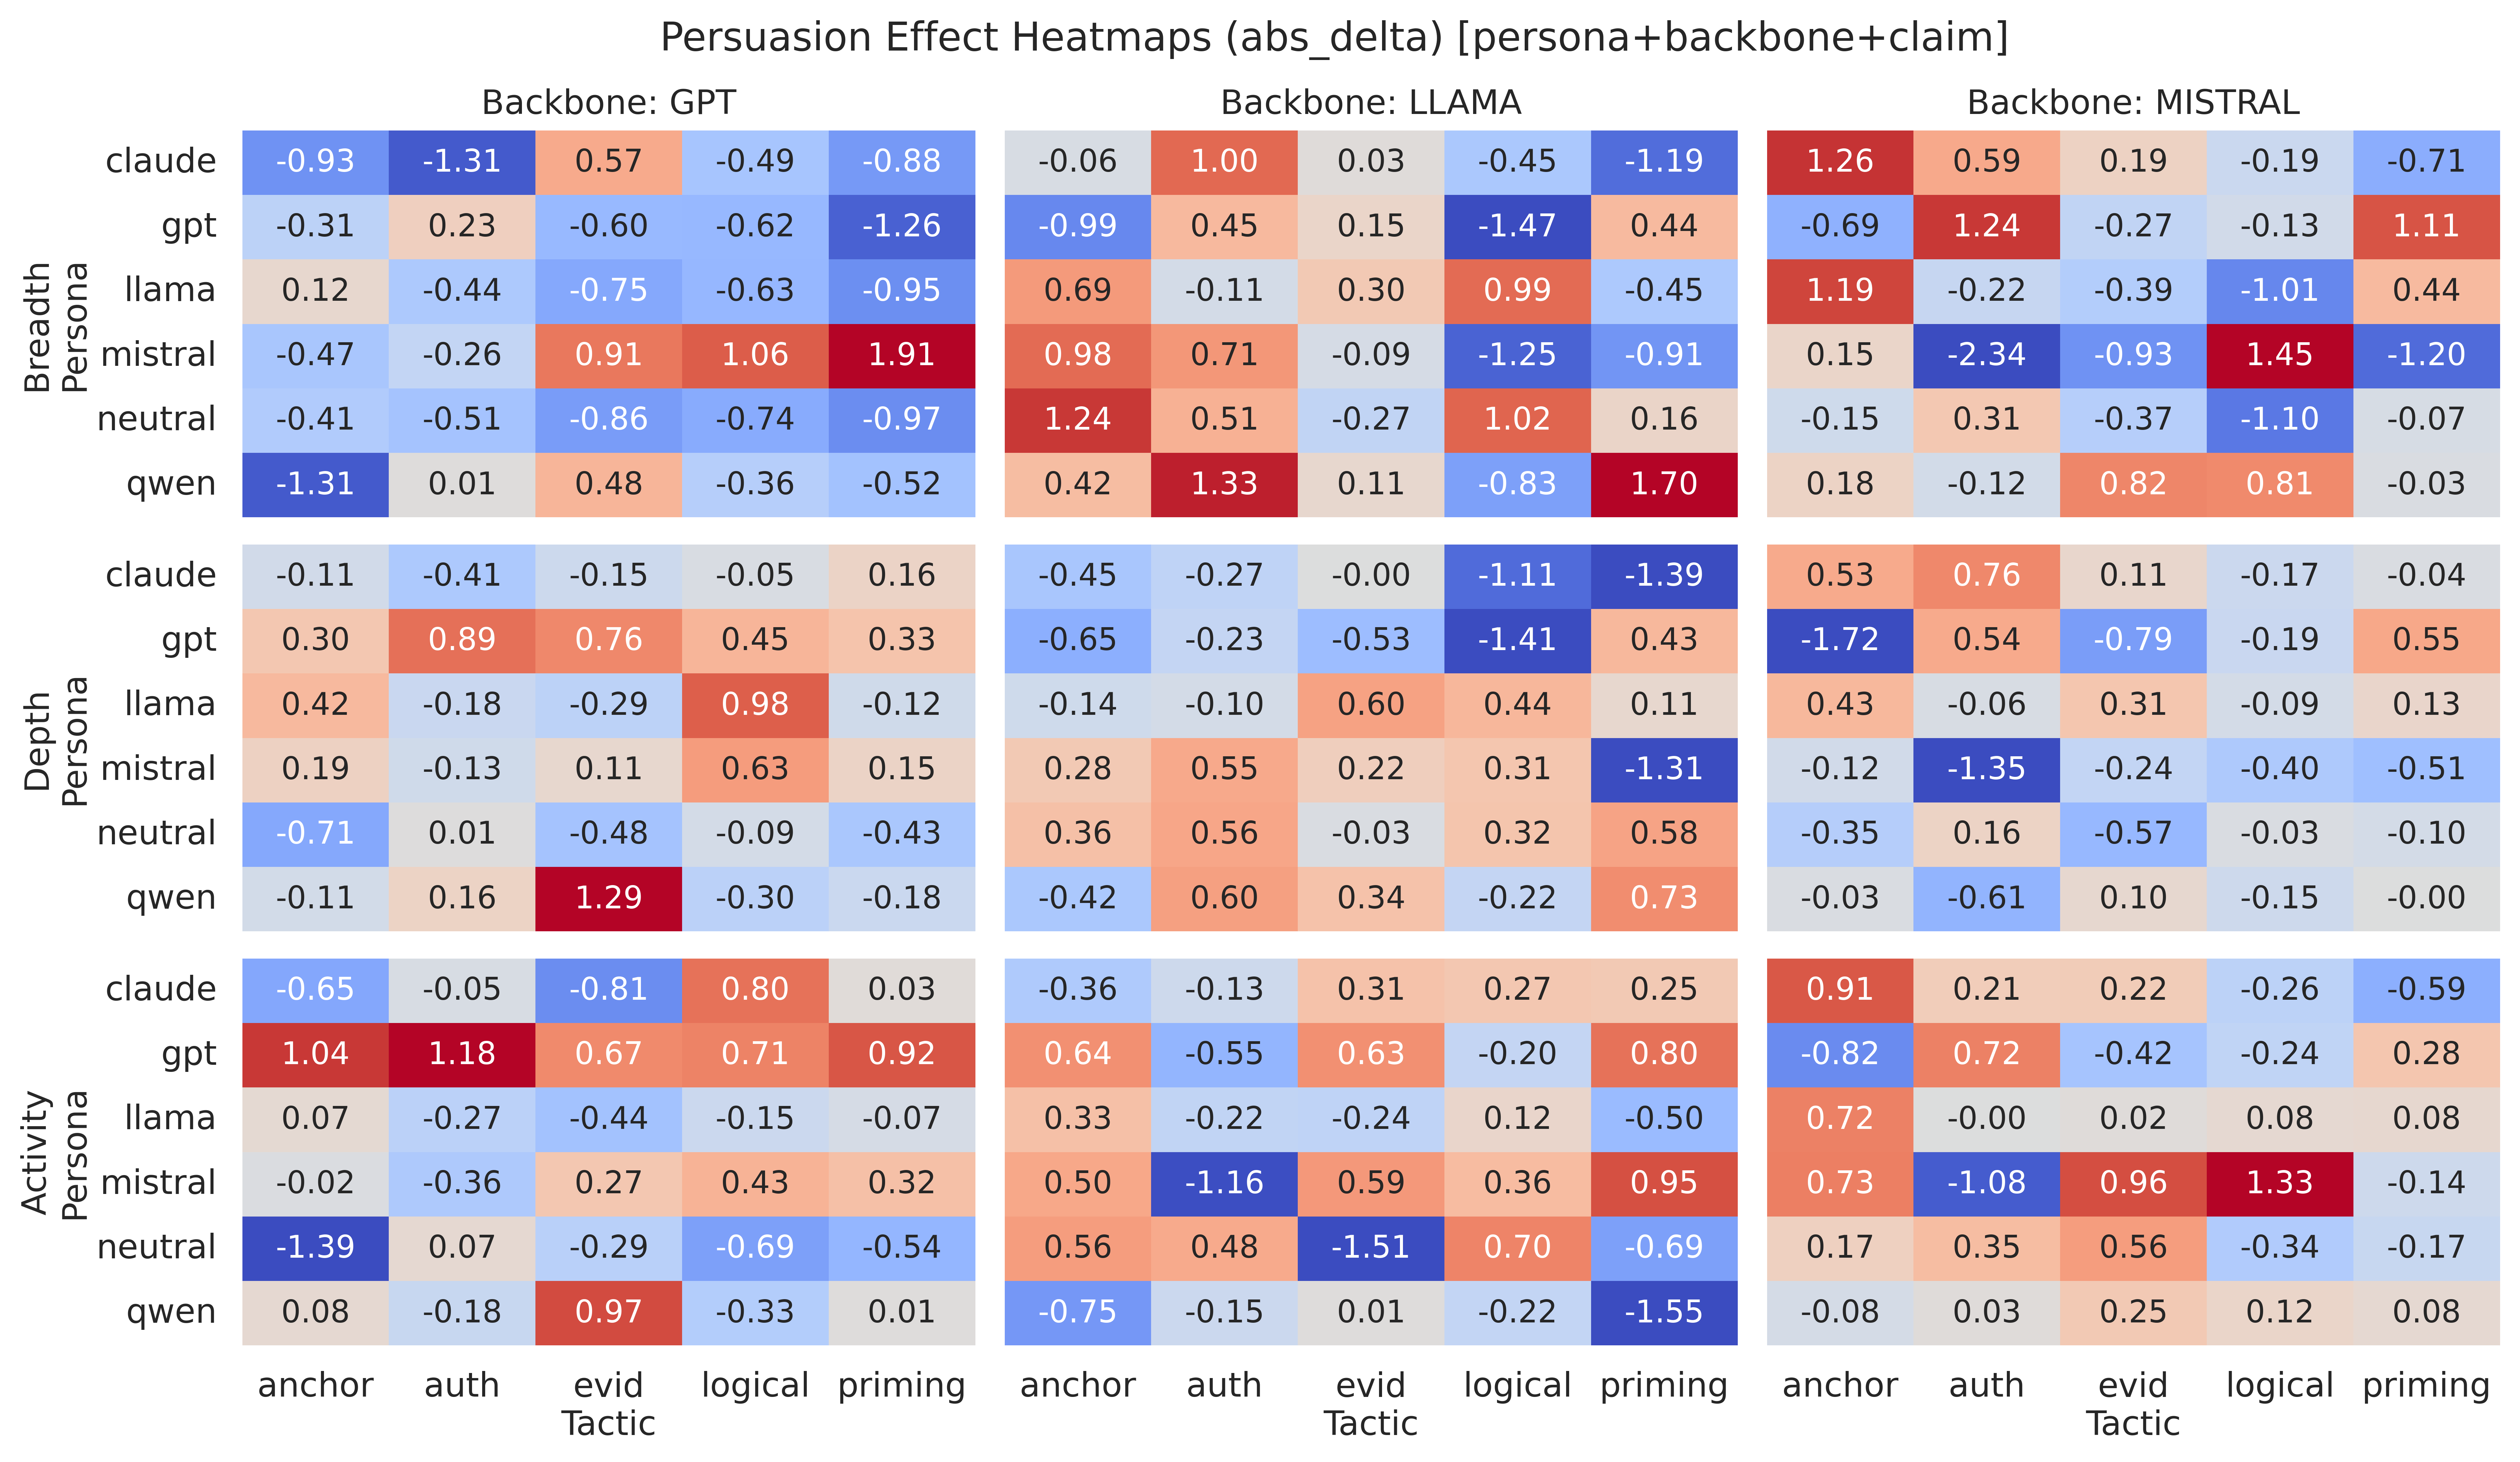


BASELINE_KEYS = ['persona', 'task_id', 'pair_id', 'backbone']


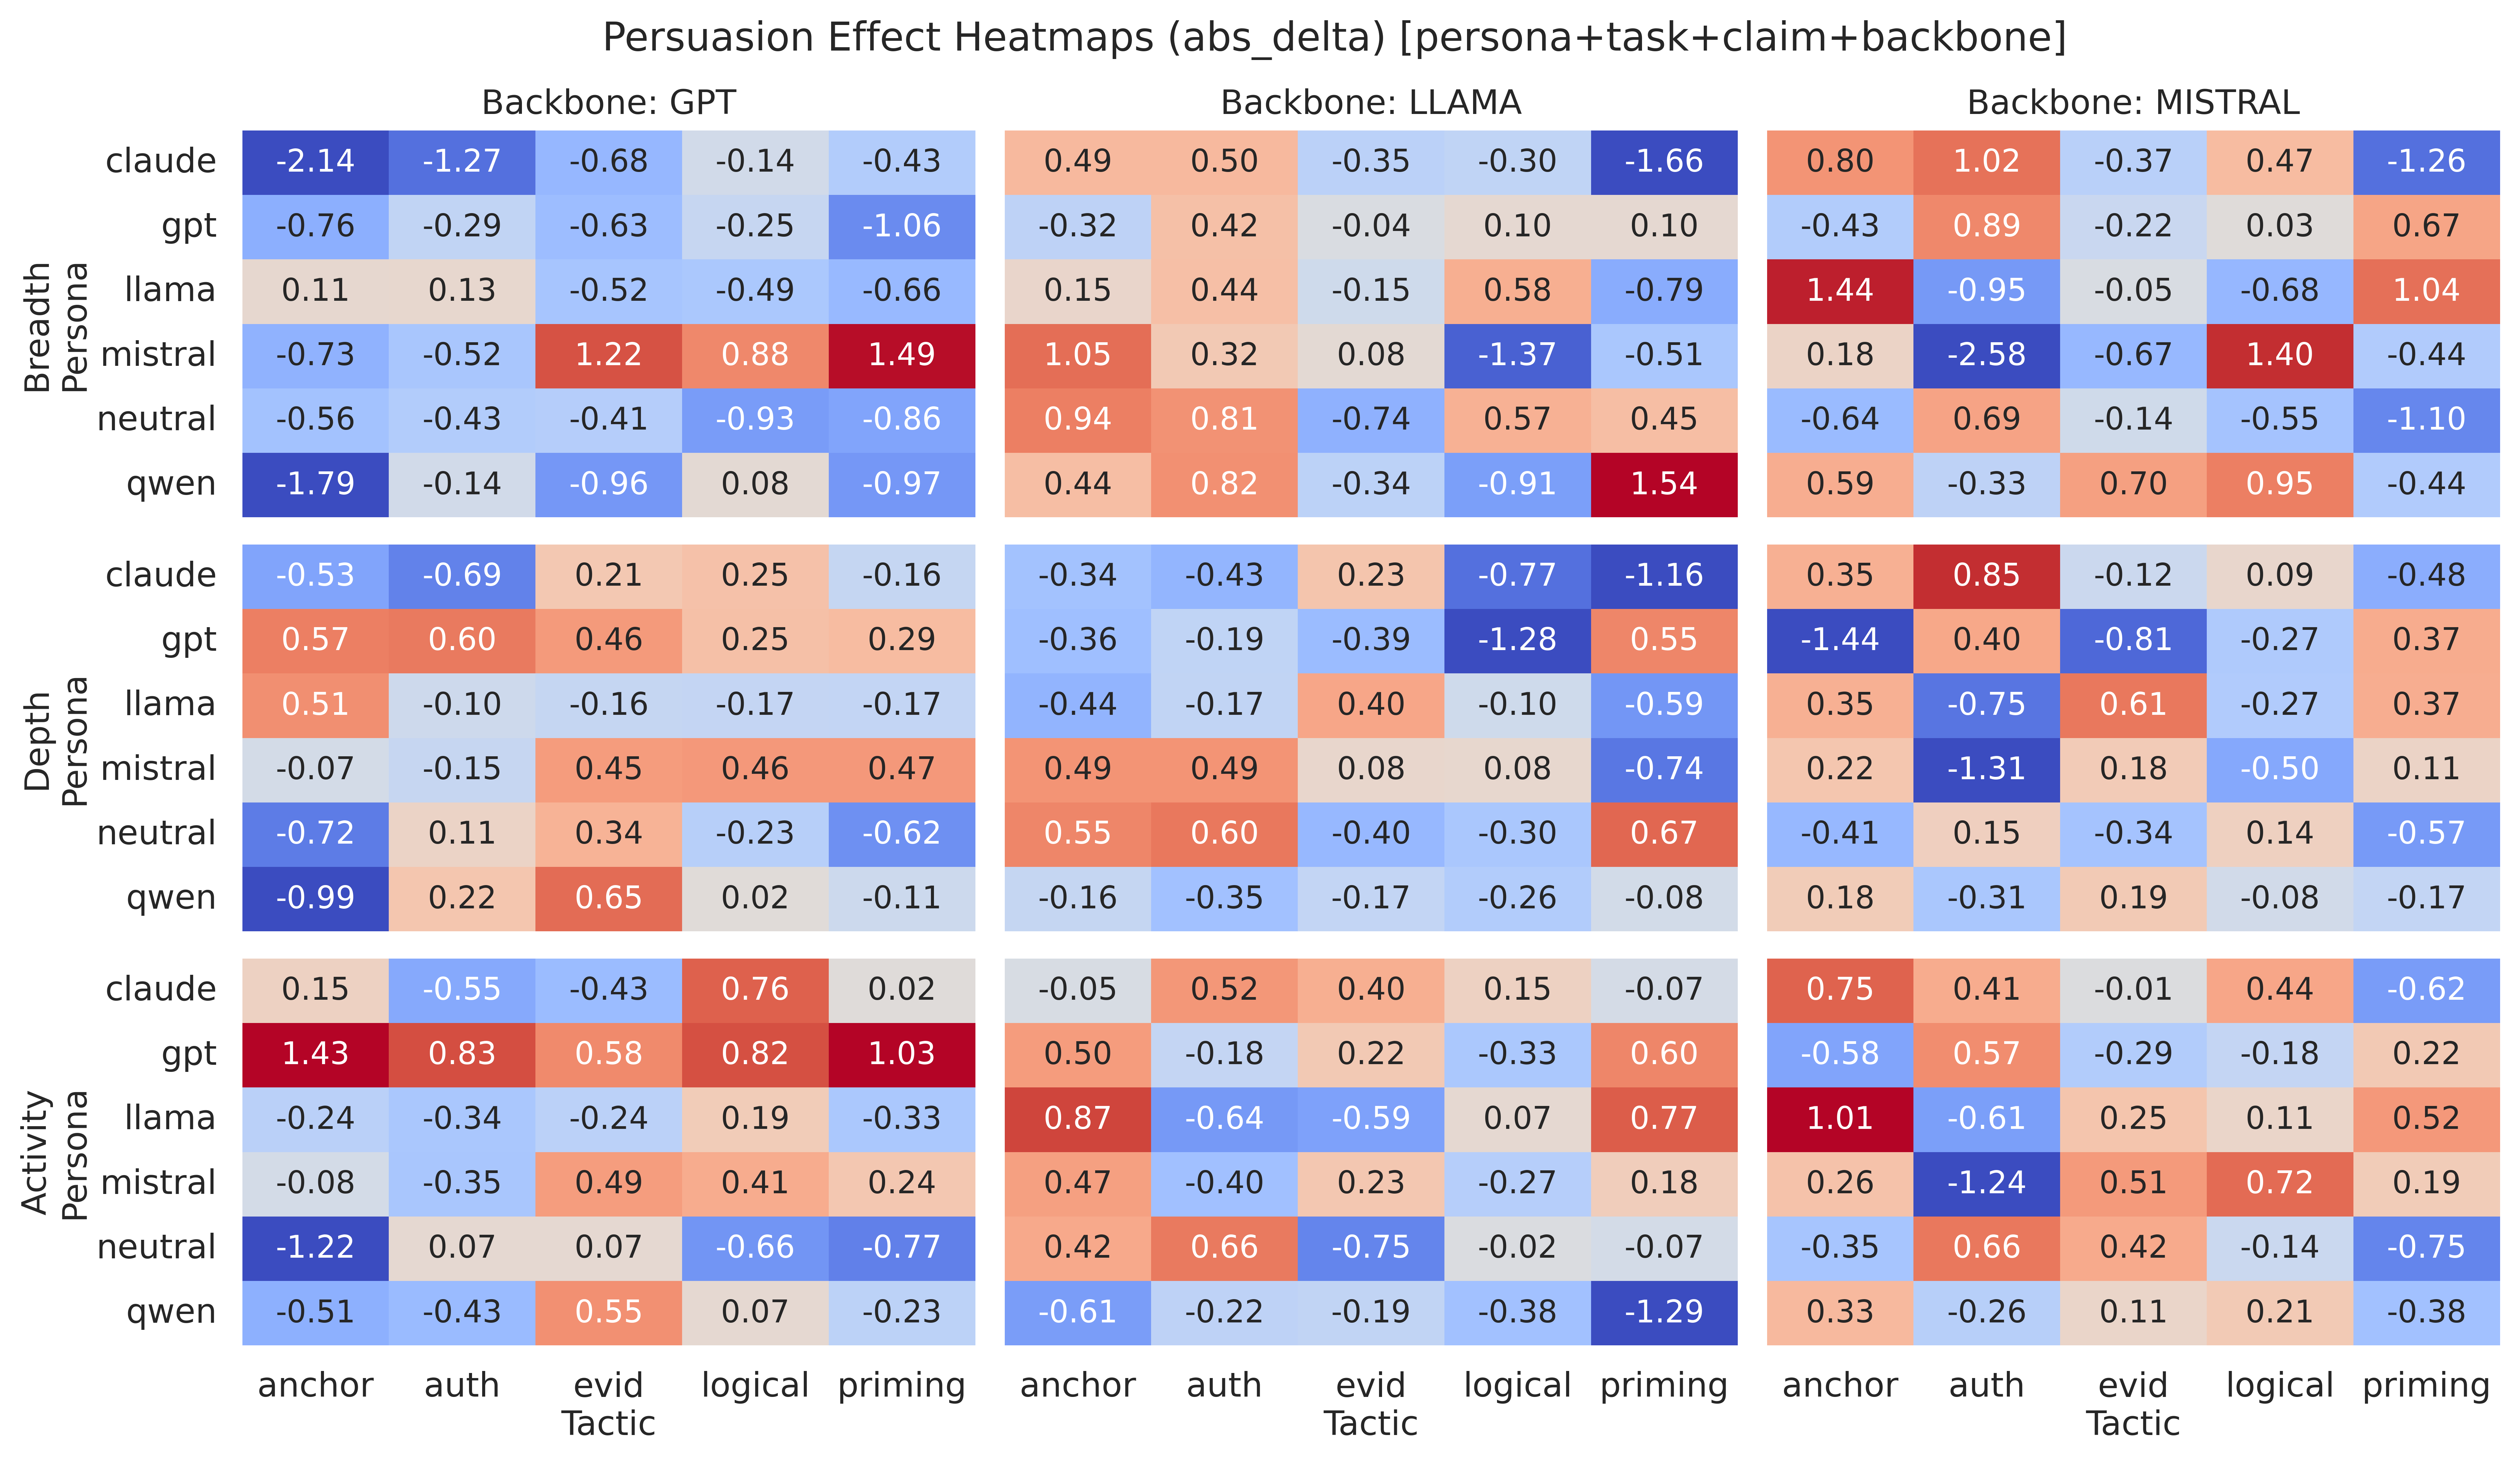

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

sns.set(style="white", context="talk")

BASELINE = "baseline"

PCS = {
    "dPC_brd": "Breadth",
    "dPC_dpt": "Depth",
    "dPC_act": "Activity",
}

backbones = ["gpt", "llama", "mistral"]
personas = None  # fill after df_merged created
tactics = None   # fill after df_merged created

# ============
# Construct metric sets
# ============
ACTIVITY = ["m_num_web_events", "m_total_duration_s", "tool_drift"]
BREADTH  = ["m_domain_entropy", "m_num_searches", "m_unique_url_ratio", "m_num_domains",
            "domain_kl", "domain_jaccard"]
DEPTH    = ["m_num_unique_urls", "m_num_summaries", "m_avg_latency_s", "query_cosine"]

drift_cols = ["query_cosine", "domain_jaccard", "domain_kl", "tool_drift"]

ANCHOR = {
    "act": "d_m_num_web_events",
    "brd": "d_m_num_domains",
    "dpt": "d_m_num_unique_urls",
}


# =========================
# Δ-PCA helper (per backbone)
# =========================
def small_pca_per_backbone(df_merged, name, metrics, drift_cols, anchor_map):
    dcols = [(f"d_{m}" if m not in drift_cols else m) for m in metrics]
    out_col = f"dPC_{name}"
    df_merged[out_col] = np.nan

    for bb, idx in df_merged.groupby("backbone").groups.items():
        X = df_merged.loc[idx, dcols]
        X = SimpleImputer(strategy="median").fit_transform(X)
        Xs = StandardScaler().fit_transform(X)

        p = PCA(n_components=1, random_state=0)
        pc = p.fit_transform(Xs).ravel()

        # anchor sign
        anchor_col = anchor_map.get(name)
        if anchor_col in dcols:
            anchor_loading = p.components_[0][dcols.index(anchor_col)]
            if anchor_loading < 0:
                pc *= -1.0

        df_merged.loc[idx, out_col] = pc

    return df_merged


# =========================
# Baseline merge + deltas
def build_df_merged_for_keys(df_raw, baseline_keys):
    """
    Returns df_merged: non-baseline rows merged with baseline mean (same baseline_keys)
    and with delta metrics d_m_* computed.

    Works for BOTH:
      (A) raw traces with 'behavioral_metrics' column
      (B) already-flattened dfs with m_* columns
    """
    df = df_raw.copy()

    # -------------------------
    # 1) Ensure we have m_* cols
    # -------------------------
    if "behavioral_metrics" in df.columns:
        metrics_df = pd.json_normalize(df["behavioral_metrics"]).add_prefix("m_")
        df = pd.concat([df.drop(columns=["behavioral_metrics"]), metrics_df], axis=1)

    # sanity check
    m_cols = [c for c in df.columns if c.startswith("m_")]
    if len(m_cols) == 0:
        raise ValueError("No m_* metric columns found. Did you flatten behavioral_metrics already?")

    # -------------------------
    # 2) Ratios (only if needed)
    # -------------------------
    eps = 1e-6
    if "m_unique_url_ratio" not in df.columns:
        if "m_num_unique_urls" in df.columns and "m_num_urls" in df.columns:
            df["m_unique_url_ratio"] = df["m_num_unique_urls"] / (df["m_num_urls"] + eps)

    if "m_url_domain_ratio" not in df.columns:
        if "m_num_domains" in df.columns and "m_num_urls" in df.columns:
            df["m_url_domain_ratio"] = df["m_num_domains"] / (df["m_num_urls"] + eps)

    # -------------------------
    # 3) baseline flag
    # -------------------------
    if "is_baseline" not in df.columns:
        df["is_baseline"] = df["tactic"].eq(BASELINE)

    # -------------------------
    # 4) baseline mean metrics
    # -------------------------
    metric_cols = [
        c for c in df.columns
        if c.startswith("m_") and c not in ["m_num_urls"]
    ]

    df_base  = df[df["is_baseline"]].copy()
    df_after = df[~df["is_baseline"]].copy()

    df_base_grp = df_base.groupby(baseline_keys, as_index=False)[metric_cols].mean()

    df_merged = df_after.merge(
        df_base_grp,
        on=baseline_keys,
        how="left",
        suffixes=("", "_base"),
        indicator=True
    )

    # keep only rows with a baseline match
    df_merged = df_merged[df_merged["_merge"] == "both"].copy()

    # -------------------------
    # 5) deltas d_m_*
    # -------------------------
    for m in metric_cols:
        df_merged[f"d_{m}"] = df_merged[m] - df_merged[m + "_base"]

    return df_merged

# =========================
# Heatmap plotting function
# =========================
def plot_construct_heatmap_by_persona(
    df_merged,
    title_suffix="",
    use_percent_change=True,
    backbones=("gpt", "llama", "mistral"),
):
    """
    Heatmaps where:
      - subplot grid = (PC rows) × (Persona cols)
      - each heatmap shows: rows=backbone, cols=tactic
      - values = delta(P - NP) or % change
    """

    df_merged = df_merged.copy()

    # ensure condition exists
    if "condition" not in df_merged.columns:
        df_merged["condition"] = df_merged["persuaded"].map({1: "persuaded", 0: "not_persuaded"})

    personas = sorted(df_merged["persona"].unique())
    tactics  = sorted(df_merged["tactic"].unique())
    backbones = list(backbones)

    def pretty_tactic(t):
        mapping = {
            "authority_endorsement": "authority",
            "logical_appeal": "logical",
            "evidence_based": "evidence",
            "priming_urgency": "priming",
        }
        return mapping.get(t, t)

    EPS = 1e-6

    fig, axes = plt.subplots(
        nrows=len(PCS),
        ncols=len(personas),
        figsize=(5.0 * len(personas), 1.55 * len(PCS)),
        dpi=600,
        sharey=True
    )

    # always force axes to be 2D
    if len(PCS) == 1:
        axes = axes[np.newaxis, :]
    if len(personas) == 1:
        axes = axes[:, np.newaxis]

    for row_idx, (pc, pc_label) in enumerate(PCS.items()):

        summary = (
            df_merged
            .groupby(["persona", "backbone", "tactic", "condition"])[pc]
            .mean()
            .reset_index()
        )

        pivot = summary.pivot_table(
            index=["persona", "backbone", "tactic"],
            columns="condition",
            values=pc
        ).reset_index()

        # compute effect
        if use_percent_change:
            pivot["val"] = (
                (pivot["persuaded"] - pivot["not_persuaded"])
                / (pivot["not_persuaded"].abs() + EPS)
            ) * 100.0
            fmt = ".1f"
            val_label = "%change"
        else:
            pivot["val"] = pivot["persuaded"] - pivot["not_persuaded"]
            fmt = ".2f"
            val_label = "Δ(P-NP)"

        vmax = pivot["val"].abs().quantile(0.95)

        for col_idx, persona in enumerate(personas):
            ax = axes[row_idx, col_idx]

            sub = pivot[pivot["persona"] == persona]

            mat = (
                sub.pivot(index="backbone", columns="tactic", values="val")
                .reindex(index=backbones, columns=tactics)
            )

            sns.heatmap(
                mat,
                ax=ax,
                cmap="coolwarm",
                center=0,
                vmin=-vmax,
                vmax=vmax,
                annot=True,
                fmt=fmt,
                cbar=False,
                annot_kws={"size": 12},
                linewidths=0
            )

            # titles
            if row_idx == 0:
                ax.set_title(f"Persona: {persona}", fontsize=12)

            # y-axis labels
            if col_idx == 0:
                ax.set_ylabel(f"{pc_label}\nBackbone", fontsize=12, labelpad=2)
                ax.set_yticks(np.arange(len(backbones)) + 0.5)
                ax.set_yticklabels(backbones, rotation=0, fontsize=11)
            else:
                ax.set_ylabel("")
                ax.set_yticklabels([])

            # x-axis labels
            if row_idx == len(PCS) - 1:
                ax.set_xlabel("Tactic", fontsize=12)
                ax.set_xticklabels(
                    [pretty_tactic(t.get_text()) for t in ax.get_xticklabels()],
                    rotation=15,
                    fontsize=11,
                )
            else:
                ax.set_xlabel("")
                ax.set_xticklabels([])

    plt.suptitle(f"Persuasion Effect Heatmaps ({val_label}) {title_suffix}", fontsize=14, y=1.02)
    plt.subplots_adjust(wspace=0.05, hspace=0.14)
    plt.show()

def plot_construct_heatmap(df_merged, title_suffix="", use_percent_change=False):
    """
    Heatmap of persuaded vs not_persuaded difference
    (either absolute Δ or % change)
    """
    global personas, tactics

    df_merged = df_merged.copy()
    df_merged["condition"] = df_merged["persuaded"].map({1: "persuaded", 0: "not_persuaded"})

    personas = sorted(df_merged["persona"].unique())
    tactics = sorted(df_merged["tactic"].unique())

    fig, axes = plt.subplots(
        nrows=len(PCS),
        ncols=len(backbones),
        figsize=(4.8 * len(backbones), 2.6 * len(PCS)),
        dpi=600,
        sharey=True
    )

    def pretty_tactic(t):
        mapping = {
            "authority_endorsement": "auth",
            "logical_appeal": "logical",
            "evidence_based": "evid",
            "priming_urgency": "priming",
            "anchoring": "anchor",
        }
        return mapping.get(t, t)

    EPS = 1e-6

    for row_idx, (pc, pc_label) in enumerate(PCS.items()):
        summary = (
            df_merged
            .groupby(["persona", "backbone", "tactic", "condition"])[pc]
            .mean()
            .reset_index()
        )

        pivot = summary.pivot_table(
            index=["persona", "backbone", "tactic"],
            columns="condition",
            values=pc
        ).reset_index()

        if use_percent_change:
            pivot["delta"] = (
                (pivot["persuaded"] - pivot["not_persuaded"])
                / (pivot["not_persuaded"].abs() + EPS)
            ) * 100.0
            fmt = ".1f"
            value_label = "pct_change"
        else:
            pivot["delta"] = (pivot["persuaded"] - pivot["not_persuaded"])
            fmt = ".2f"
            value_label = "abs_delta"

        vmax = pivot["delta"].abs().quantile(0.95)

        for col_idx, backbone in enumerate(backbones):
            ax = axes[row_idx, col_idx]

            sub = pivot[pivot["backbone"] == backbone]

            mat = (
                sub.pivot(index="persona", columns="tactic", values="delta")
                .reindex(index=personas, columns=tactics)
            )

            sns.heatmap(
                mat,
                ax=ax,
                cmap="coolwarm",
                center=0,
                vmin=-vmax,
                vmax=vmax,
                annot=True,
                fmt=fmt,
                cbar=False,
                annot_kws={"size": 11},
                linewidths=0
            )

            ax.tick_params(axis="x", pad=0)
            ax.tick_params(axis="y", pad=0)

            if row_idx == 0:
                ax.set_title(f"Backbone: {backbone.upper()}", fontsize=12)

            if col_idx == 0:
                ax.set_ylabel(f"{pc_label}\nPersona", fontsize=12, labelpad=2)
                ax.set_yticks(np.arange(len(personas)) + 0.5)
                ax.set_yticklabels(personas, rotation=0, fontsize=12)
            else:
                ax.set_ylabel("")

            if row_idx == len(PCS) - 1:
                ax.set_xlabel("Tactic", fontsize=12, labelpad=2)
                ax.set_xticklabels(
                    [pretty_tactic(t.get_text()) for t in ax.get_xticklabels()],
                    rotation=0,
                    fontsize=12,
                )
            else:
                ax.set_xlabel("")
                ax.set_xticklabels([])

    plt.suptitle(f"Persuasion Effect Heatmaps ({value_label}) {title_suffix}", fontsize=14, y=.95)
    plt.subplots_adjust(wspace=0.04, hspace=0.07)
    plt.show()


# =========================
# MAIN: run for each baseline granularity
# =========================
BASELINE_SETTINGS = {
    "persona+backbone": ["persona", "backbone"],
    "persona+backbone+task": ["persona", "task_id", "backbone"],
    "persona+backbone+claim": ["persona", "pair_id", "backbone"],
    "persona+task+claim+backbone": ["persona", "task_id", "pair_id", "backbone"],
}

for setting_name, keys in BASELINE_SETTINGS.items():
    print("\n==============================")
    print(f"BASELINE_KEYS = {keys}")
    print("==============================")

    df_merged = build_df_merged_for_keys(df, keys)

    # run construct PCA per backbone
    df_merged = small_pca_per_backbone(df_merged, "act", ACTIVITY, drift_cols, ANCHOR)
    df_merged = small_pca_per_backbone(df_merged, "brd", BREADTH,  drift_cols, ANCHOR)
    df_merged = small_pca_per_backbone(df_merged, "dpt", DEPTH,    drift_cols, ANCHOR)

    # plot: absolute deltas (recommended)
    plot_construct_heatmap(df_merged, title_suffix=f"[{setting_name}]", use_percent_change=False)

    # OPTIONAL: percent change version (less recommended for PCA scores)
    # plot_construct_heatmap(df_merged, title_suffix=f"[{setting_name}] %change", use_percent_change=True)


In [38]:
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# CONFIG
# ------------------------------------------------------------
BACKBONE_ORDER = ["gpt", "mistral", "llama"]

PERSONA_ORDER = ["neutral", "gpt", "mistral", "llama", "claude", "qwen"]
PERSONA_LABEL = {
    "neutral": "Neutral",
    "gpt": "GPT",
    "mistral": "Mistral",
    "llama": "LLaMA",
    # "gemini": "Gemini",
    "claude": "Claude",
    "qwen": "Qwen",
}

TACTIC_ORDER = [
    "anchoring",
    "logical_appeal",
    "authority_endorsement",
    "evidence_based",
    "priming_urgency",
]

TACTIC_LABEL = {
    "anchoring": "Anchoring",
    "logical_appeal": "Logical",
    "authority_endorsement": "Authority",
    "evidence_based": "Evidence",
    "priming_urgency": "Priming",
}

PCS = {
    "dPC_brd": "Breadth",
    "dPC_dpt": "Depth",
    "dPC_act": "Activity",
}

ND = 3


# ------------------------------------------------------------
# helpers
# ------------------------------------------------------------
def fmt_delta_with_counts(delta, nNP, nP, nd=ND):
    if delta is None or (isinstance(delta, float) and np.isnan(delta)):
        return ""
    sign = "+" if delta >= 0 else ""
    return f"{sign}{delta:.{nd}f}"


def compute_persona_tactic_delta(df_merged, pc_col, min_group=1):
    """
    Returns df with columns:
      persona, tactic, backbone, Delta, nNP, nP
    Delta = mean(P) - mean(NP)
    """
    rows = []
    for (persona, tactic, backbone), g in df_merged.groupby(["persona", "tactic", "backbone"]):
        np_vals = g[g["persuaded"] == 0][pc_col].dropna()
        p_vals  = g[g["persuaded"] == 1][pc_col].dropna()

        nNP = len(np_vals)
        nP  = len(p_vals)

        if nNP < min_group or nP < min_group:
            continue

        mu_np = float(np_vals.mean())
        mu_p  = float(p_vals.mean())
        delta = mu_p - mu_np

        rows.append({
            "persona": persona,
            "tactic": tactic,
            "backbone": backbone,
            "Delta": delta,
            "nNP": int(nNP),
            "nP": int(nP),
        })

    return pd.DataFrame(rows)


def build_persona_tactic_delta_rows(df_merged, nd=ND, min_group=1):
    """
    Output format (row per persona×tactic):
      Persona & Tactic &
      [gpt BrdΔ] [gpt DptΔ] [gpt ActΔ] &
      [mistral BrdΔ] ... &
      [llama BrdΔ] ...
    """
    lookup = {}
    for pc in PCS.keys():
        lookup[pc] = compute_persona_tactic_delta(df_merged, pc, min_group=min_group)

    lines = []

    for persona in PERSONA_ORDER:
        for tactic in TACTIC_ORDER:
            persona_label = PERSONA_LABEL.get(persona, persona)
            tactic_label = TACTIC_LABEL.get(tactic, tactic)

            parts = [persona_label, tactic_label]

            for backbone in BACKBONE_ORDER:
                for pc in PCS.keys():
                    tab = lookup[pc]
                    hit = tab[
                        (tab["persona"] == persona)
                        & (tab["tactic"] == tactic)
                        & (tab["backbone"] == backbone)
                    ]

                    if len(hit) == 0:
                        parts += [""]
                        continue

                    delta = float(hit.iloc[0]["Delta"])
                    nNP   = int(hit.iloc[0]["nNP"])
                    nP    = int(hit.iloc[0]["nP"])

                    parts += [fmt_delta_with_counts(delta, nNP, nP, nd)]

            # skip empty rows (if EVERYTHING is missing)
            if all(x == "" for x in parts[2:]):
                continue

            lines.append(" & ".join(parts) + r" \\")
    return lines


# ------------------------------------------------------------
# RUN
# ------------------------------------------------------------
print("\n===== LaTeX rows: persona × tactic × backbone × (Brd/Dpt/Act) Δ + (nNP/nP) =====\n")
rows = build_persona_tactic_delta_rows(df_merged, nd=ND, min_group=1)
for r in rows:
    print(r)



===== LaTeX rows: persona × tactic × backbone × (Brd/Dpt/Act) Δ + (nNP/nP) =====

Neutral & Anchoring & -0.564 & -0.716 & -1.221 & -0.644 & -0.408 & -0.352 & +0.942 & +0.548 & +0.425 \\
Neutral & Logical & -0.930 & -0.233 & -0.663 & -0.552 & +0.142 & -0.136 & +0.569 & -0.305 & -0.017 \\
Neutral & Authority & -0.428 & +0.110 & +0.066 & +0.687 & +0.150 & +0.663 & +0.808 & +0.605 & +0.658 \\
Neutral & Evidence & -0.405 & +0.337 & +0.066 & -0.144 & -0.339 & +0.419 & -0.744 & -0.405 & -0.745 \\
Neutral & Priming & -0.862 & -0.624 & -0.769 & -1.103 & -0.572 & -0.749 & +0.449 & +0.668 & -0.074 \\
GPT & Anchoring & -0.762 & +0.572 & +1.433 & -0.434 & -1.440 & -0.582 & -0.322 & -0.363 & +0.501 \\
GPT & Logical & -0.247 & +0.254 & +0.824 & +0.034 & -0.275 & -0.176 & +0.100 & -1.282 & -0.327 \\
GPT & Authority & -0.288 & +0.595 & +0.831 & +0.888 & +0.397 & +0.573 & +0.417 & -0.185 & -0.177 \\
GPT & Evidence & -0.627 & +0.460 & +0.582 & -0.222 & -0.809 & -0.290 & -0.039 & -0.390 & +0.220 \\
GPT &

# Coding Task Analysis

In [11]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

MODEL_FILES = {
    "gpt-4.1-nano": "../exp2_results/coding-gpt-all.jsonl",
    "mistral-nemo-12b": "../exp2_results/coding-mistral-all.jsonl",
    "llama-3.1-8b": "../exp2_results/coding-llama-all.jsonl",
}

BASELINE = "baseline"

TRS_METRICS = ["coding_duration_s", "trial_duration_s", "num_code_revisions"]
EVS_METRICS = ["revision_entropy", "mean_revision_size"]


In [22]:
def percentile_rank_nan_safe(x):
    x = pd.Series(x)
    out = pd.Series(np.nan, index=x.index, dtype=float)
    mask = x.notna()
    out.loc[mask] = x.loc[mask].rank(pct=True)
    return out.values


def baseline_delta_quantiles(df, metrics):
    base = (
        df[df["tactic"] == BASELINE]
        .groupby("persona")[metrics]
        .mean()
        .rename(columns={m: f"{m}_base" for m in metrics})
    )

    df2 = df[df["tactic"] != BASELINE].merge(base, on="persona", how="left")

    for m in metrics:
        df2[f"d_{m}"] = df2[m] - df2[f"{m}_base"]
        df2[f"q_{m}"] = percentile_rank_nan_safe(df2[f"d_{m}"])

    return df2

def baseline_delta_quantiles_prefill(df, baseline_mask, metrics):
    base = (
        df[baseline_mask]
        .groupby("persona")[metrics]
        .mean()
        .rename(columns={m: f"{m}_base" for m in metrics})
    )

    df2 = df.merge(base, on="persona", how="left")

    for m in metrics:
        df2[f"d_{m}"] = df2[m] - df2[f"{m}_base"]
        df2[f"q_{m}"] = percentile_rank_nan_safe(df2[f"d_{m}"])

    return df2


def compute_trs_evs_scores(df):
    df = df.copy()

    # ---- TRS ----
    trs_df = baseline_delta_quantiles(df, TRS_METRICS)
    trs_df["trs_score"] = 1.0 - trs_df[[f"q_{m}" for m in TRS_METRICS]].mean(axis=1)

    # ---- EVS ----
    evs_df = baseline_delta_quantiles(df, EVS_METRICS)
    evs_df["q_mean_revision_size_inv"] = 1.0 - evs_df["q_mean_revision_size"]
    evs_df["evs_score"] = evs_df[["q_revision_entropy", "q_mean_revision_size_inv"]].mean(axis=1)

    out = trs_df[["persona", "persuaded", "trs_score"]].copy()
    out["evs_score"] = evs_df["evs_score"].values
    return out


def pooled_np_p_test(df, score_col):
    np_vals = df[df["persuaded"] == 0][score_col].dropna()
    p_vals  = df[df["persuaded"] == 1][score_col].dropna()

    u, p = mannwhitneyu(np_vals, p_vals, alternative="two-sided")

    return {
        "NP_mean": np_vals.mean(),
        "P_mean": p_vals.mean(),
        "Δ(P−NP)": p_vals.mean() - np_vals.mean(),
        "p_value": p,
        "n_NP": len(np_vals),
        "n_P": len(p_vals),
    }

def persona_delta_summary(df, score_col):
    deltas = []

    for persona, g in df.groupby("persona"):
        np_vals = g[g["persuaded"] == 0][score_col].dropna()
        p_vals  = g[g["persuaded"] == 1][score_col].dropna()
        if len(np_vals) == 0 or len(p_vals) == 0:
            continue
        deltas.append(p_vals.mean() - np_vals.mean())

    deltas = np.array(deltas)

    return {
        "mean_Δ": deltas.mean(),
        "std_Δ": deltas.std(ddof=1),
        "IQR_Δ": np.percentile(deltas, 75) - np.percentile(deltas, 25),
        "frac_pos": (deltas > 0).mean(),
        "n_personas": len(deltas),
    }


def load_jsonl(path, backbone="gpt"):
    df = pd.read_json(path, lines=True)
    df["backbone"] = backbone
    return df


def compute_trs_evs_prefill(df):
    baseline_mask = df["prefill_condition"] == "C0"

    # ---- TRS ----
    trs_df = baseline_delta_quantiles_prefill(
        df, baseline_mask, TRS_METRICS
    )
    trs_df["trs_score"] = 1.0 - trs_df[
        [f"q_{m}" for m in TRS_METRICS]
    ].mean(axis=1)

    # ---- EVS ----
    evs_df = baseline_delta_quantiles_prefill(
        df, baseline_mask, EVS_METRICS
    )
    evs_df["q_mean_revision_size_inv"] = 1.0 - evs_df["q_mean_revision_size"]
    evs_df["evs_score"] = evs_df[
        ["q_revision_entropy", "q_mean_revision_size_inv"]
    ].mean(axis=1)

    out = trs_df[["persona", "prefill_condition", "trs_score"]].copy()
    out["evs_score"] = evs_df["evs_score"].values
    return out

def pooled_np_p_stats(df, score_col, n_boot=2000, seed=0):
    rng = np.random.default_rng(seed)

    np_vals = df[df["prefill_condition"] == "NP"][score_col].dropna().values
    p_vals  = df[df["prefill_condition"] == "P"][score_col].dropna().values

    delta = p_vals.mean() - np_vals.mean()

    # Mann–Whitney U
    _, pval = mannwhitneyu(np_vals, p_vals, alternative="two-sided")

    # Bootstrap CI
    boot = []
    for _ in range(n_boot):
        bp = rng.choice(p_vals, size=len(p_vals), replace=True).mean()
        bnp = rng.choice(np_vals, size=len(np_vals), replace=True).mean()
        boot.append(bp - bnp)

    ci_lo, ci_hi = np.percentile(boot, [2.5, 97.5])

    return {
        "NP_mean": np_vals.mean(),
        "P_mean": p_vals.mean(),
        "Δ(P−NP)": delta,
        "p": pval,
        "CI95": (ci_lo, ci_hi),
        "n_NP": len(np_vals),
        "n_P": len(p_vals),
    }



In [13]:
rows = []

for backbone, path in MODEL_FILES.items():
    df = pd.read_json(path, lines=True)
    df = df[df["persona"] != "gemini"]
    df_scored = compute_trs_evs_scores(df)

    for score_col, label in [("trs_score", "TRS"), ("evs_score", "EVS")]:
        pooled = pooled_np_p_test(df_scored, score_col)
        persona = persona_delta_summary(df_scored, score_col)

        rows.append({
            "Backbone": backbone,
            "Score": label,
            "Δ_mean": pooled["Δ(P−NP)"],
            "p_value": pooled["p_value"],
            "persona_IQR": persona["IQR_Δ"],
            "persona_std": persona["std_Δ"],
            # "frac_positive_personas": persona["frac_pos"],
        })

summary_df = pd.DataFrame(rows)
display(summary_df)


Backbone Score    Δ_mean   p_value  persona_IQR  persona_std
0      gpt-4.1-nano   TRS -0.022430  0.289394     0.064113     0.049042
1      gpt-4.1-nano   EVS -0.002843  0.713831     0.013198     0.010318
2  mistral-nemo-12b   TRS  0.024794  0.210249     0.073444     0.062382
3  mistral-nemo-12b   EVS -0.001481  0.552571     0.034148     0.021277
4      llama-3.1-8b   TRS  0.030689  0.074933     0.013973     0.030931
5      llama-3.1-8b   EVS -0.003231  0.688363     0.041112     0.045062

In [ ]:
plot_rows = []

for backbone, path in MODEL_FILES.items():
    df = pd.read_json(path, lines=True)
    df = df[df["persona"] != "gemini"]
    df_scored = compute_trs_evs_scores(df)

    for score_col, label in [("trs_score", "TRS"), ("evs_score", "EVS")]:
        for persona, g in df_scored.groupby("persona"):
            np_vals = g[g["persuaded"] == 0][score_col]
            p_vals  = g[g["persuaded"] == 1][score_col]
            if len(np_vals) == 0 or len(p_vals) == 0:
                continue
            plot_rows.append({
                "Backbone": backbone,
                "Score": label,
                "Persona": persona,
                "Δ(P−NP)": p_vals.mean() - np_vals.mean(),
            })

plot_df = pd.DataFrame(plot_rows)

plt.figure(figsize=(7,4))
sns.boxplot(data=plot_df, x="Score", y="Δ(P−NP)", hue="Backbone")
plt.axhline(0, color="black", linestyle="--", linewidth=1)
plt.title("Persona-level NP–P deltas: TRS vs EVS")
plt.tight_layout()
plt.show()


In [23]:
df = load_jsonl(
    "../exp2_results/gpt-prefill-coding-gpt-evidence_based-all_runs.jsonl",
    backbone="gpt"
)

# sanity filters
df = df[
    (df["persona"] == "gpt") &
    (df["tactic"] == "evidence_based")
].copy()

# compute scores
df_scored = compute_trs_evs_prefill(df)

# run stats
rows = []
for score, label in [("trs_score", "TRS"), ("evs_score", "EVS")]:
    stats = pooled_np_p_stats(
        df_scored[df_scored["prefill_condition"] != "C0"],
        score
    )
    rows.append({
        "Score": label,
        **stats
    })

summary = pd.DataFrame(rows)
display(summary)


Score   NP_mean    P_mean   Δ(P−NP)         p  \
0   TRS  0.500796  0.465419 -0.035377  0.150325   
1   EVS  0.497532  0.493968 -0.003564  0.893531   

                                           CI95  n_NP  n_P  
0  (-0.08421313333333331, 0.015402466666666625)   250  250  
1    (-0.02779276666666672, 0.0195884333333333)   250  250